# Clustering and validation
In this script we cluster pull request graphs and their associated feature vectors that capture the structural properties of the graphs. We arrive at a final partition of 5 group type.


In [1]:
import networkx as nx
import pickle
from scipy.spatial import distance
import numpy as np
import seaborn as sns
from collections import defaultdict
from itertools import combinations
import matplotlib as mp
import matplotlib.pyplot as plt
from nxpd import draw
from IPython.display import display
import operator
import random
import community
import MySQLdb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

Graphs and feature vectors have been prepared in a separate script.

Load network data

In [2]:
networkl=pickle.load(open("data/networks8to20", "rb"))

Load feature vectors that have been precalculated in different notebook

In [3]:
feature_vecs_8to20 = pickle.load( open("data/feature_vecs_8to20.p", "rb"))

In [4]:

colors=["#35a8e0", "#05c100", "#ffd300",'#d8b69f', '#d1000a']

# connect to ghtorrent db dump
db=MySQLdb.connect(
                 host="127.0.0.1",
                 user="root",
                 passwd="enterenter"
               )
cursor = db.cursor()
cursor.execute("use ghtorrent_restore")


def get_project_info(_id):
    cursor.execute("select owner_id, name from projects where id=%s"%(_id))
    project_data=cursor.fetchone()
    name=project_data[1]
    # get owner login name
    owner_id = project_data[0]
    cursor.execute("select * from users where id=%s"%(owner_id))
    owner=cursor.fetchone()
    #returns name, owner id, owner login name, user type
    return (name, owner[0], owner[1], owner[4])

def get_user(_id):
    cursor.execute("select * from users where id=%s"%(_id))
    return cursor.fetchone()

def get_commits(p_id, u_id):
    cursor.execute("""select * from commits c, project_commits pc
                          where pc.project_id=%s
                          and pc.commit_id=c.id
                          and (c.author_id=%s or c.committer_id=%s)
        
    """%(p_id,u_id,u_id))
    return cursor.fetchall()

def get_graph_by_id(_id):
    return next(nw for nw in networkl if nw.graph['id']==_id)

def draw_github_project(_id,node_color="black"):
    testnw=next(nw for nw in networkl if nw.graph['id']==_id)
    nx.set_node_attributes(testnw, node_color ,'color')
    for pairs in testnw.adjacency():
        for edge in pairs[1]:   
            testnw[pairs[0]][edge]['label']=str(pairs[1][edge]['weight'])
    

    fig=plt.figure(figsize=(10,2))
    project_info=get_project_info(_id)
    print("Project name: " + str(project_info[0]) + ", project owner: " + str(project_info[2]) + ", ghtorrent id: " + str(_id))
    
    return draw(testnw, show='ipynb')

def draw_graph(G,node_color):
    nx.set_node_attributes(G, node_color ,'color')
    for pairs in G.adjacency():
        for edge in pairs[1]:   
            G[pairs[0]][edge]['label']=str(pairs[1][edge]['weight'])
    
    fig=plt.figure(figsize=(10,2))
    return draw(G, show='ipynb')


def dunn_centroids(labels, vectors, min_cluster_size = 1):
    """
    Dunn index for cluster validation (larger is better).
    cluster diameter: 2* average distance from centroid.
    cluster distance: distance between cluster centroids.
    """
    labels = LabelEncoder().fit(labels).transform(labels)
    vectors = np.array(vectors)
    
    ignore_cluster = []
    for i in np.unique(labels):
        if len(labels[labels==i]) < min_cluster_size:
            ignore_cluster.append(i)
    
    #calculate centroids of each cluster
    centroids = [ np.mean(vectors[labels == i], axis=0) for i in np.unique(labels)]

    #Calculates the cluster diameters as 2 times the average distance from the centroids.
    diameters = []
    for i in np.unique(labels):
        if i not in ignore_cluster:
            diameters.append(2*np.mean([distance.seuclidean(vec, centroids[i], varis)  for vec in vectors[labels == i]]))
            
    # in case cluster does not have min_cluster_size, we remove the centroid so that it is not considered
    for index in sorted(ignore_cluster, reverse=True):
        del centroids[index]
        
    #Calculates the distances between the centroids of each cluster.
    ic_distances = [distance.seuclidean(centroids[i], centroids[j], varis) for i in range(len(centroids)) for j in range(i+1, len(centroids))]
    ic_distances = np.array(ic_distances)
    
    # In the case of only one cluster, we set min_distance to zero
    if len(ic_distances)>0:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    else:
        min_distance = 0
    max_diameter = max(diameters)
    
    return min_distance / max_diameter

def connectedness(partition, l=5):
    conn = 0
    for node in partition:
        node_cl = partition[node]
        ind = index_dict[node]
        neighbors_idxs = sorted_dists[index_dict[node]][:l]
        for j,neighbor_idx in enumerate(neighbors_idxs):
            neighbor = nodes[neighbor_idx]
            if partition[neighbor]!=node_cl:
                conn+= 1/(j+1)
    return conn

In [5]:

fvs=list(feature_vecs_8to20.values())
varis=np.var(fvs, axis=0)



def get_most_representatives(node_ids, node_dict, n, nstart=0, nsample=0):
    if nsample==0:
        nsample=len(node_ids)
    node_ids=random.sample(node_ids, nsample)    
    vectors=[node_dict[nid] for nid in node_ids]
    Y=distance.pdist(vectors, 'seuclidean', V=varis)
    dsums=distance.squareform(Y).sum(axis=0)
    sorted_indeces=sorted(range(len(dsums)), key=lambda k: dsums[k])
    return [[(node_ids[i], dsums[i]/nsample) for i in sorted_indeces[nstart:nstart+n]],[(node_ids[i], dsums[i]/nsample) for i in sorted_indeces[len(sorted_indeces)-nstart-n:len(sorted_indeces)-nstart]], Y]

def get_ranking(node_ids, node_dict):  
    vectors=[node_dict[nid] for nid in node_ids]
    leng=len(node_ids)
    Y=distance.pdist(vectors, 'seuclidean', V=varis)
    dsums=distance.squareform(Y).sum(axis=0)
    sorted_indeces=sorted(range(len(dsums)), key=lambda k: dsums[k])
    sorted_dict={}
    for i,j in enumerate(sorted_indeces):
        sorted_dict[node_ids[j]]=(i+1,(i+1)/leng, dsums[j]/leng) 
        
    return sorted_dict

def draw_most_representatives(node_ids, node_dict, n, nstart=0, nsample=0, color="#000000"):
    
    data=get_most_representatives(node_ids, node_dict, n, nstart, nsample)
    
    print("Distance distribution")
    print("---------------------------------------------------------------------------------")
    #sns.distplot(data[2], hist=True, bins=200, color="g", kde=True)
    #plt.show()
    print("most central projects in cluster:")
    print("---------------------------------------------------------------------------------")
    for sample in data[0]:
        print("mean distance ", sample[1])
        display(draw_github_project(sample[0], color))
        
    print("most decentral projects in cluster:")
    print("---------------------------------------------------------------------------------")
    for sample in data[1]:
        print("mean distance ", sample[1])
        display(draw_github_project(sample[0], color))

        
def draw_most_decentral(node_ids, node_dict, n, nstart=0, nsample=0):
    
    data=get_most_representatives(node_ids, node_dict, n, nstart, nsample)
    
    print("most decentral projects in cluster:")
    print("---------------------------------------------------------------------------------")
    for sample in data[1]:
        print("mean distance ", sample[1])
        display(draw_github_project(sample[0], "#000000"))


## Plot distance distribution for projects

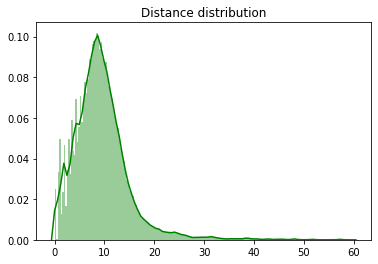

In [6]:
Y=distance.pdist([feature_vecs_8to20[k] for k in feature_vecs_8to20], 'seuclidean', V=varis)
sns.distplot(Y, hist=True, bins=200, color="g", kde=True)
plt.title("Distance distribution")
plt.show()

In [7]:
np.mean(Y)

9.400243602444355

## Clustering

To find a typology of projects, we create a similarity network in which similar projects are connected by a weighted tie that depends on the distance between projects. We introduce a treshold distance at which nodes do not have a tie anymore. We do not want projects that have a great distance to be connected. At the same time we do not want the cluster solution to depend explicitly on the treshold. We therefore vary the threshold and try to find a stable cluster solution. We vary the treshold starting roughly from the  mean distance between all project to two times the mean distance (i.e from 10 to 19). 

In [8]:
len([d for d in Y if d < 19])/len(Y)

0.953354808134783

The treshold of 19 includes more than 95 percent of all ties.
To calculate the similarity we normalize the distances d with min-max standardization (min=0, max=treshold) s to the interval [0,1] and the similarity between two projects becomes s = 1 - s(d).
We use the Louvain clustering algorithm for different values of the treshold and for different values of the resolution parameter.

Sidenote: For the clustering to be meaningful, we want as much variety in the weights as possible. If we do not set a threshold and then do a min-max standardization to calculate the similarities, the majority of all pairs would  have a very high similarity, because of the skewed distribution. For example as you can see above 95 percent of all project pairs would have a similarity weight of greater than ~ (60-20)/60 = 0.66. 

In [9]:
np.random.seed(seed=123)

fv_keys=feature_vecs_8to20.keys()
no_partitions=defaultdict(list)
partitions={}
modularities={}

nodes= fv_keys
Y=distance.pdist([feature_vecs_8to20[node] for node in nodes], 'seuclidean', V=varis)


for treshold in range(10,20,1):
    tuples=combinations(nodes,2)
    G=nx.Graph()
    G.add_weighted_edges_from([(*indeces,(treshold - dist)/treshold) for indeces, dist in zip(tuples,Y) if dist < treshold ])

    G_nodes=G.nodes
    for node in nodes:
        if node not in G_nodes:
            G.add_node(node)
    #compute the best partition
    
   
    for res in [(0.1*x+0.7) for x in range(10)]:
        partition = community.best_partition(G, resolution=res)
        modularity=community.modularity(partition, G, weight='weight')
        name="tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:3]
        partitions[name]=partition
        modularities[name]=modularity
        no_partitions[str(treshold)].append(len(set(partition.values())))
    
   

In [10]:
pickle.dump(partitions, open("data/partitions_level1", "wb"))
pickle.dump(modularities, open("data/modularities_level1", "wb"))

In [11]:
partitions = pickle.load(open("data/partitions_level1", "rb"))
modularities = pickle.load(open("data/modularities_level1", "rb"))

In [12]:
fvs=list(feature_vecs_8to20.values())
varis=np.var(fvs, axis=0)
std=np.std(fvs, axis=0)

def normalize(x):
    return np.array([x[i]/std[i] for i in range(len(x))])

feature_vecs_normalized = {x:normalize(v) for x,v in feature_vecs_8to20.items()}

# Explore number of clusters
we check the number of clusters  that have at least 20 projects. 
This is ok, because we want to find a typology of groups so there should be at least a decent amount of projects in a cluster for a typology to make sense.

In [13]:
no_p_clean=[]
no_singlets=[]
for treshold in range(10,20,1):
    counts=[]
    singletsn=[]
    for res in [(0.1*x+0.7) for x in range(10)]:
        name="tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:3]
        tp=partitions[name]
        d = defaultdict(int)
        for k,v in tp.items():
            d[v]+=1

        count=0
        singlets=0
        for k,v in d.items():
            # only count partitions that have at least 20 projects
            if v>20:
                count+=1
            else:
                singlets+=1
        counts.append(count)
        singletsn.append(singlets)
    no_p_clean.append(counts)
    no_singlets.append(singletsn)


    

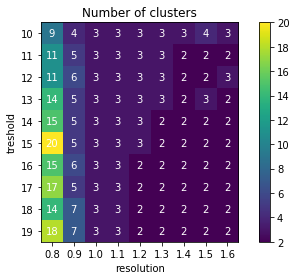

In [14]:
xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6']
yticks=['10','11', '12', '13', '14', '15', '16', '17', '18', '19']

dmat=np.array([x[1:] for x in no_p_clean])

fig, ax = plt.subplots()
im = ax.imshow(dmat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*dmat.nonzero()):
    ax.text(j, i, dmat[i, j], color='white', ha='center', va='center')

ax.set_title("Number of clusters")
plt.xlabel("resolution")
plt.ylabel("treshold")
fig.tight_layout()
plt.colorbar(im)
plt.show()

we also check the number of clusters  that have at least  **200 projects**. 

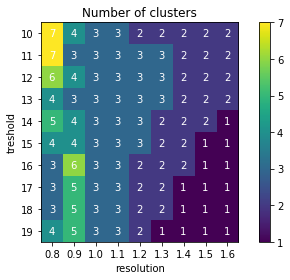

In [15]:
no_p_clean=[]
no_singlets=[]
for treshold in range(10,20,1):
    counts=[]
    singletsn=[]
    for res in [(0.1*x+0.7) for x in range(10)]:
        name="tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:3]
        tp=partitions[name]
        d = defaultdict(int)
        for k,v in tp.items():
            d[v]+=1

        count=0
        singlets=0
        for k,v in d.items():
            # only count partitions that have at least 20 projects
            if v>200:
                count+=1
            else:
                singlets+=1
        counts.append(count)
        singletsn.append(singlets)
    no_p_clean.append(counts)
    no_singlets.append(singletsn)


xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6']
yticks=['10','11', '12', '13', '14', '15', '16', '17', '18', '19']

dmat=np.array([x[1:] for x in no_p_clean])

fig, ax = plt.subplots()
im = ax.imshow(dmat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*dmat.nonzero()):
    ax.text(j, i, dmat[i, j], color='white', ha='center', va='center')

ax.set_title("Number of clusters")
plt.xlabel("resolution")
plt.ylabel("treshold")
fig.tight_layout()
plt.colorbar(im)
fig.savefig('clustermatrix.png', dpi=300)
plt.show()

We see that many of the cluster solutions in the right bottom consist of only 1 big cluster (and maybe some additional very small clusters).
We see that for varying tresholds, the only stable plateaus are at resolutions 1.0 and 1.1 with three cluster solutions.
To pick between these values and explore the cluster solutions further, we calculate three cluster validity indeces. 

The first is modularity, which the Louvain algorithm that we used tries to maximize.

The second index is Connectedness which takes into account wether neigbouring nodes are in the same cluster (smaller values are better).

The third index is dunn's index.

# Stability of cluster solutions

To have a quantitative measure for the stability of the cluster solutions with respect to the treshold parameter we calculate
both the adjusted rand score and the adjusted mutual information for each pair of cluster solutions with the same resolution parameter. 

In [16]:
nodes = list(feature_vecs_8to20.keys())
resolutions = [(0.1*x+0.7) for x in range(10)]
avg_ari = []
ari_matrices = []
avg_ami = []
ami_matrices = []

for res in resolutions:
    names=["tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:3] for treshold in range(10,20,1)]
    ari_matrix=[]
    ami_matrix=[]
    for i in range(len(names)):
        arr_ari = []
        arr_ami = []
        for j in range(len(names)):
            p1 = partitions[names[i]]
            p2 = partitions[names[j]]
            ari = adjusted_rand_score([p1[n] for n in nodes], [p2[n] for n in nodes])
            ami = adjusted_mutual_info_score([p1[n] for n in nodes], [p2[n] for n in nodes])
            arr_ari.append(ari)       
            arr_ami.append(ami)
        ari_matrix.append(arr_ari)
        ami_matrix.append(arr_ami)
    ari_matrices.append(ari_matrix)
    ami_matrices.append(ami_matrix)
    avg_ari.append(np.mean(ari_matrix))
    avg_ami.append(np.mean(ami_matrix))
    

/home/trurl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Below we plot the average adjusted rand index and the average adjusted mutual information for all pairs of partitions from the cluster solutions with the same resolution parameter. We clearly see a maximum in partition stability for the cluster solutions with resolution parameter 1.0, where the obtained partitions show the highes congruence for different tresholds.

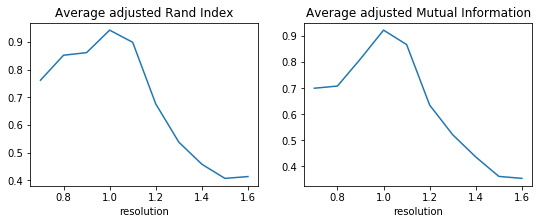

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(resolutions, avg_ari)
axs[0].set_title("Average adjusted Rand Index")
axs[0].set_xlabel("resolution")

axs[1].plot(resolutions, avg_ami)
axs[1].set_title("Average adjusted Mutual Information")
axs[1].set_xlabel("resolution")
plt.show()

# modularity

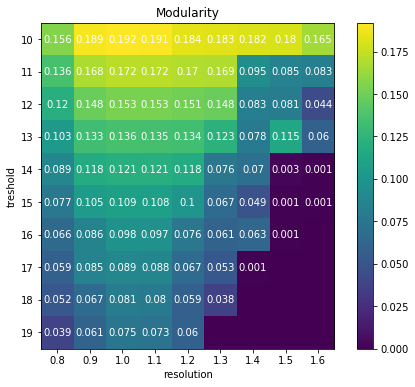

In [18]:
modularities_plot=[]
for treshold in range(10,20,1):
    m_arr = []
    for res in [(0.1*x+0.8) for x in range(9)]:
        name="tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:3]
        m = modularities[name]
        m_arr.append(m)
    modularities_plot.append(m_arr)

modularities_coeff=np.round(np.array(modularities_plot),3)

fig, ax = plt.subplots(figsize = (8,6) )
im = ax.imshow(modularities_coeff)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*modularities_coeff.nonzero()):
    ax.text(j, i, modularities_coeff[i, j], color='white', fontsize = 10, ha='center', va='center')

plt.colorbar(im)
ax.set_title("Modularity")
plt.xlabel("resolution")
plt.ylabel("treshold")
plt.show()

We see that the maximum modularity is consistently reached at resolution parameters 1.0 followed by 1.1 with nearly identical modularities.
Generally modularity is higher for smaller tresholds. This is due to the fact, that each treshold corresponds to a different graph, where a higher treshold means that nodes with greater distance still share a tie. So it only makes sense to  compare cluster solutions for the same threshold graph.

# connectedness

In [19]:
nodes = list(feature_vecs_8to20.keys())
dists=distance.pdist([feature_vecs_8to20[node] for node in nodes], 'seuclidean', V=varis)
dists = distance.squareform(dists)
sorted_dists = [np.argsort(dists[i]) for i in range(len(nodes))]
sorted_dists = [sorted_dists[i][sorted_dists[i]!=i] for i in range(len(nodes))] #remove the distance to itself (which of course are zeros)
index_dict = {node:i for i,node in enumerate(nodes)} 

def connectedness(partition, l=5):
    conn = 0
    for node in partition:
        node_cl = partition[node]
        ind = index_dict[node]
        neighbors_idxs = sorted_dists[index_dict[node]][:l]
        for j,neighbor_idx in enumerate(neighbors_idxs):
            neighbor = nodes[neighbor_idx]
            if partition[neighbor]!=node_cl:
                conn+= 1/(j+1)
    return conn/len(partition)

connectedness_dict = {}
for key in partitions:
    c = connectedness(partitions[key],5)
    connectedness_dict[key]=c

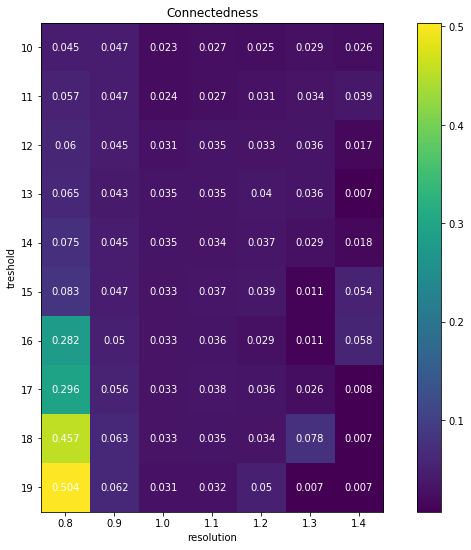

In [20]:
xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4']
yticks=['10', '11', '12','13', '14', '15', '16', '17', '18', '19']

connectivities_plot=[]
for treshold in range(10,20,1):
    m_arr = []
    for res in [(0.1*x+0.8) for x in range(7)]:
        name="tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:4]
        m = connectedness_dict[name]
        m_arr.append(m)
    connectivities_plot.append(m_arr)

connectivities_coeff=np.round(np.array(connectivities_plot),3)

fig, ax = plt.subplots(figsize = (12,9) )
im = ax.imshow(connectivities_coeff)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*connectivities_coeff.nonzero()):
    ax.text(j, i, connectivities_coeff[i, j], color='white', fontsize = 10, ha='center', va='center')
plt.colorbar(im)
ax.set_title("Connectedness")
plt.xlabel("resolution")
plt.ylabel("treshold")
plt.show()

Connectedness seems to reach a minimum at res = 1.0. There are some smaller values for connectedness at higher values for the resolution parameter, but these are due to cluster solutions with only one very big cluster (see exploration for the number of clusters above). If there only is a single cluster, all neigbors are obviously in the same cluster, so connectedness becomes optimal ~ 0.

Besides, for higher values of the resolution parameter, the solutions and their associated values for connectedness are unstable with respect to the treshold and we are looking for a stable solution.


# dunn's index

In [21]:
dunns_index_centroids_dict = {}
for key in partitions:
    partition = partitions[key]
    nodes = list(partition.keys())
    vecs=[feature_vecs_8to20[n] for n in nodes]
    labels = [partition[n] for n in nodes]
    di = dunn_centroids(labels, vecs)
    dunns_index_centroids_dict[key]=di

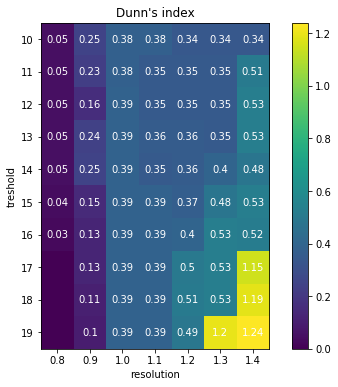

In [22]:

xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4']
yticks=['10', '11', '12','13', '14', '15', '16', '17', '18', '19']

dunns_index_centroids_plot=[]
for treshold in range(10,20,1):
    m_arr = []
    for res in [(0.1*x+0.8) for x in range(7)]:
        name="tresh" + str(treshold) + "-res-"+str(np.round(res,1))[:4]
        m = dunns_index_centroids_dict[name]
        m_arr.append(m)
    dunns_index_centroids_plot.append(m_arr)

dunns_index_centroids_coeff=np.round(np.array(dunns_index_centroids_plot),2)

fig, ax = plt.subplots(figsize = (8,6) )
im = ax.imshow(dunns_index_centroids_coeff)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*dunns_index_centroids_coeff.nonzero()):
    ax.text(j, i, dunns_index_centroids_coeff[i, j], color='white', fontsize = 10, ha='center', va='center')

plt.colorbar(im)
ax.set_title("Dunn's index")
plt.xlabel("resolution")
plt.ylabel("treshold")
#fig.tight_layout()
#plt.colorbar(modularities_coeff)
#fig.savefig('clustermatrix.png', dpi=300)
plt.show()

We see that for resolution r = 1.0 the dunn's index reaches a stable plateau, which is more stable and on average higher than that for r = 1.1.
There are some cluster solutions with a higher dunn's index for higher values of the resolution parameters.

But for higher values of the resolution parameter, the solutions and their associated Dunn's indeces are unstable with respect to the treshold and we are looking for a stable solution.
Also, the highest values for the Dunn's index are reached for the treshold, resolution pairs (19,1.3), (19,1.4), (18,1.3) and (17,1.15) where the solution basically consists of only one very big cluster (see exploration for the number of clusters above) and where the modularity of the solution is zero.

Dunn's index is known to work well for sperically shaped and compact clusters and has its shortcomings  for hypersperical and noisy datasets. Putting our emphasis on cluster stability, connectedness and the modularity of the solution (which is the quantity that we set out to optimize)  we proceed with the solutions around resolution parameter 1.0.
-> We thus proceed with the stable solutions at resolution 1.0. 

### Exploration of the solutions at resolution r = 1.0

Print the number of projects in clusters for different treshold parameters and resolution = 1.0

In [23]:
compare_ps=['tresh10-res-1.0','tresh11-res-1.0', 'tresh12-res-1.0', 'tresh13-res-1.0', 'tresh14-res-1.0', 'tresh15-res-1.0', 'tresh16-res-1.0', 'tresh17-res-1.0', 'tresh18-res-1.0', 'tresh19-res-1.0']
for k in compare_ps:
    print(k)
    p=partitions[k]
    cluster0=[x for x in p if p[x]==0]
    cluster1=[x for x in p if p[x]==1]
    cluster2=[x for x in p if p[x]==2]
    cluster3=[x for x in p if p[x]==3]
    cluster4=[x for x in p if p[x]==4]
    print("cluster 0: ", len(cluster0))
    print("cluster 1: ", len(cluster1))
    print("cluster 2: ", len(cluster2))
    print("cluster 3: ", len(cluster3))
    print("cluster 4: ", len(cluster4))
    print("\n")

tresh10-res-1.0
cluster 0:  2108
cluster 1:  1777
cluster 2:  1639
cluster 3:  4
cluster 4:  1


tresh11-res-1.0
cluster 0:  2130
cluster 1:  1752
cluster 2:  1646
cluster 3:  1
cluster 4:  1


tresh12-res-1.0
cluster 0:  2149
cluster 1:  1618
cluster 2:  1762
cluster 3:  1
cluster 4:  0


tresh13-res-1.0
cluster 0:  2153
cluster 1:  1578
cluster 2:  1798
cluster 3:  1
cluster 4:  0


tresh14-res-1.0
cluster 0:  2163
cluster 1:  1546
cluster 2:  1820
cluster 3:  1
cluster 4:  0


tresh15-res-1.0
cluster 0:  2173
cluster 1:  1496
cluster 2:  1860
cluster 3:  1
cluster 4:  0


tresh16-res-1.0
cluster 0:  2178
cluster 1:  1488
cluster 2:  1864
cluster 3:  0
cluster 4:  0


tresh17-res-1.0
cluster 0:  2182
cluster 1:  1480
cluster 2:  1868
cluster 3:  0
cluster 4:  0


tresh18-res-1.0
cluster 0:  2183
cluster 1:  1475
cluster 2:  1872
cluster 3:  0
cluster 4:  0


tresh19-res-1.0
cluster 0:  2183
cluster 1:  1472
cluster 2:  1875
cluster 3:  0
cluster 4:  0




The cluster solutions above are very similar as we showed already in the stability analysis before.
To tidy up the clusters and to make sure that our final cluster solution does not depend on a single value of the treshold parameter, we only keep the projects that are consistently classified in the same cluster for different treshold values. 
For a good cluster solution the treshold should not have an influence.

In [24]:
cluster0s=set(cluster0)
cluster1s=set(cluster1)
cluster2s=set(cluster2)
cluster3s=set(cluster3)
for key in compare_ps:
    partition=partitions[key]
    cluster0=[x for x in partition if partition[x]==0]
    cluster1=[x for x in partition if partition[x]==1]
    cluster2=[x for x in partition if partition[x]==2]
    cluster3=[x for x in partition if partition[x]==3]
    cluster0s=cluster0s.intersection(set(cluster0))
    cluster1s=cluster1s.intersection(set(cluster1))
    cluster2s=cluster2s.intersection(set(cluster2))
    cluster3s=cluster3s.intersection(set(cluster3))
print("cluster 0: ", len(cluster0s))
print("cluster 1: ", len(cluster1s))
print("cluster 2: ", len(cluster2s))
print("cluster 3: ", len(cluster3s))
print("")

cluster 0:  2108
cluster 1:  1472
cluster 2:  1634
cluster 3:  0



In the garbage set we collect all projects that have not been consistently grouped in the same cluster for different treshold values. In the following we display and explore some examples of these projects.

In [25]:
garbage=set(partition.keys()).difference(cluster0s,cluster1s,cluster2s,cluster3s)

In [26]:
len(garbage)

316

we see that in total 316 projects have been inconsistently grouped. Since they can not unambigously be assigned to a certain cluster, we do not include them in the subsequent analysis of the clusters.

 Dunn's index depends on the maximum inner cluster diameter and the min intra cluster distance.
 By discarding projects that have been inconsistently clustered, we effectively discard projects on the border between clusters.
 That of course means that the Dunn's index should have improved.

### Explore cluster 1 (cluster0s)

To see what kind of projects are in the first cluster (cluster0s) we desplay the 10 projects that on average have the smallest distance to all other projects in the cluster.
Furthermore, the function below subsequently also displays the 10 projects that have the biggest distance to all other projects in the cluster. These are the projects on the periphery of the cluster. 

We see that all projects show a star-shaped form with one central maintainer. The projects on the periphery show some complication but essentially still exhibit the star-shape. This cluster therefore has a clear and intuitive interpretation.

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  2.6070177720835943
Project name: cayenne, project owner: apache, ghtorrent id: 2336063


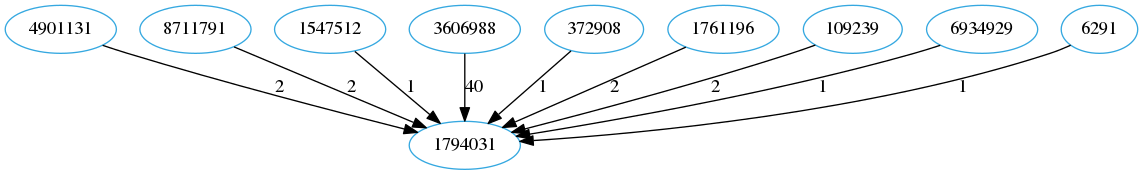

mean distance  2.6070177720835943
Project name: sublime-bookmarks, project owner: dreikanter, ghtorrent id: 10934483


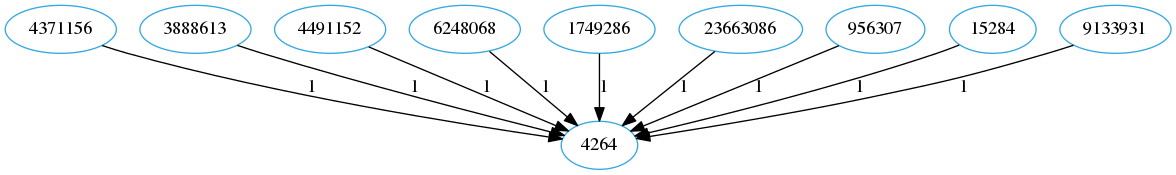

mean distance  2.6070177720835943
Project name: ai-project-2016, project owner: info-ruc, ghtorrent id: 52547291


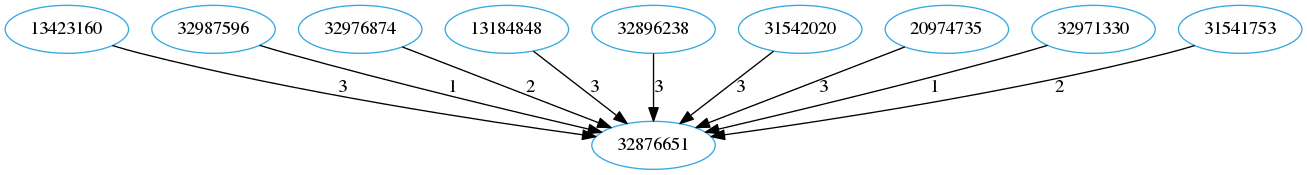

mean distance  2.6070177720835943
Project name: optim, project owner: torch, ghtorrent id: 4631399


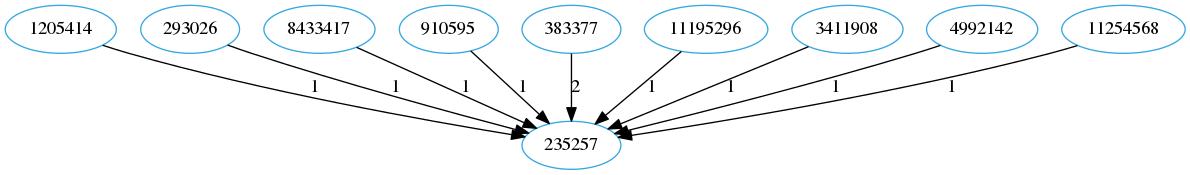

mean distance  2.6070177720835943
Project name: NAudio, project owner: naudio, ghtorrent id: 16358077


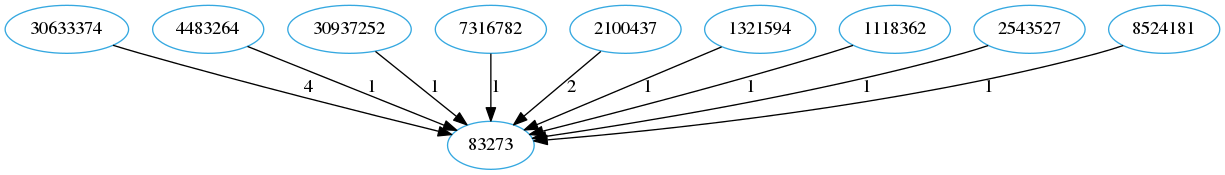

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  10.372620112018467
Project name: PromiseKit, project owner: mxcl, ghtorrent id: 8992078


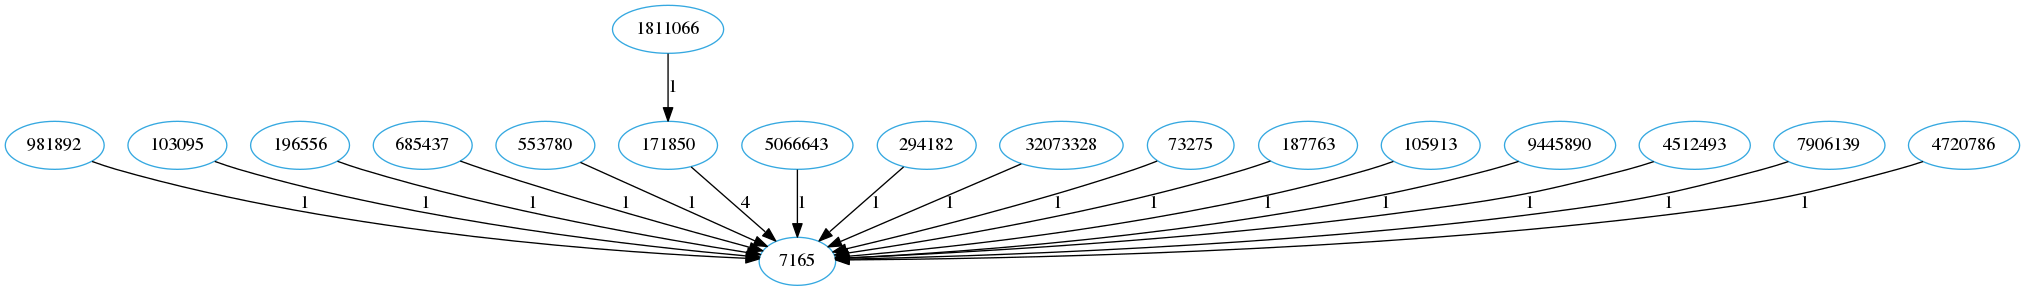

mean distance  10.372620112018467
Project name: docker-sync, project owner: EugenMayer, ghtorrent id: 40899702


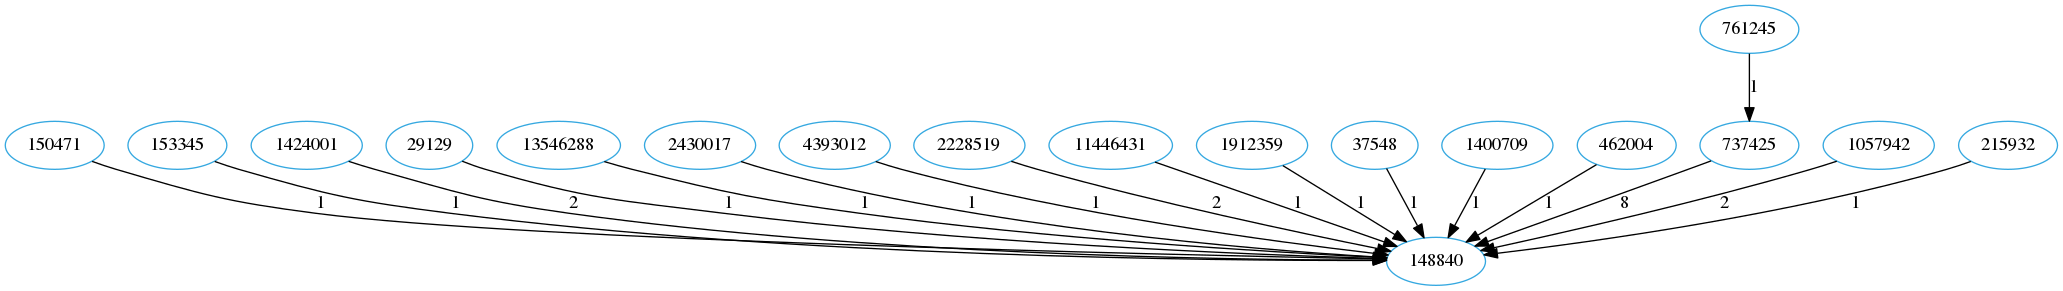

mean distance  10.793865739443891
Project name: lego, project owner: xenolf, ghtorrent id: 21239186


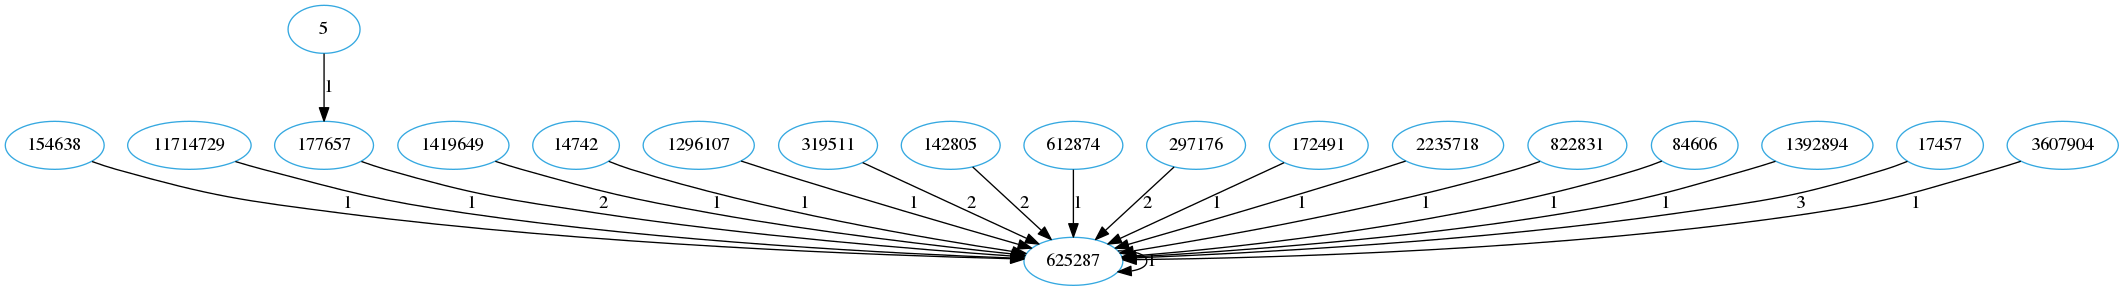

mean distance  10.841279345616767
Project name: laravel-medialibrary, project owner: Spatie, ghtorrent id: 20374325


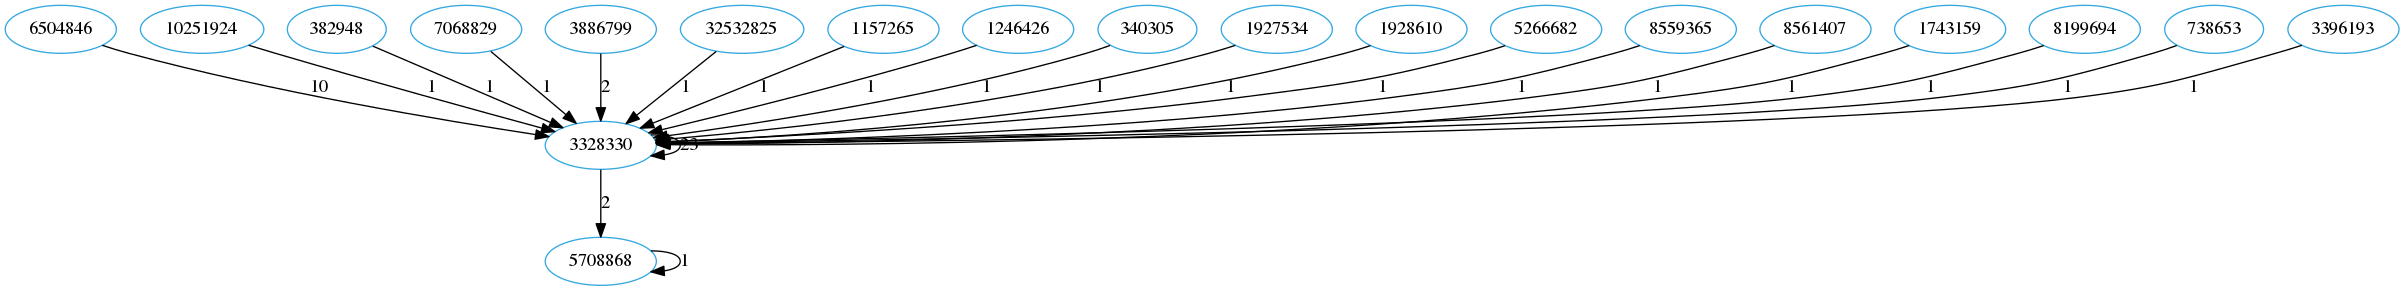

mean distance  10.959590531620869
Project name: chain, project owner: chain, ghtorrent id: 49081522


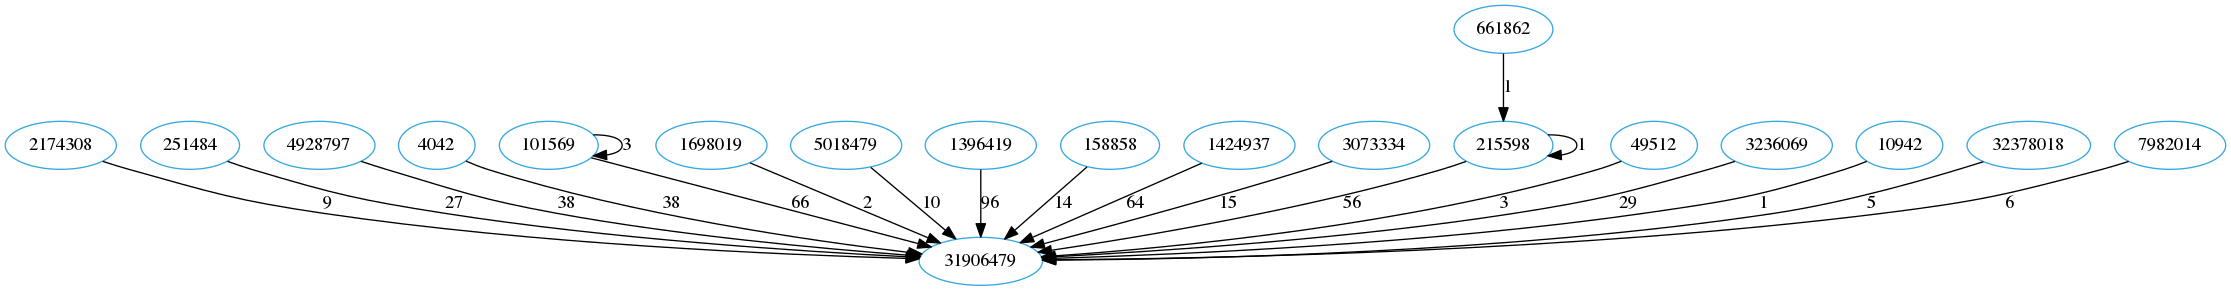

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [27]:
draw_most_representatives(cluster0s, feature_vecs_8to20, 5, 0, 0, colors[0])

### Explore  cluster 2 (cluster2s)

To see what kind of projects are in the second cluster (cluster2s) we desplay the 10 projects that on average have the smallest distance to all other projects in the cluster.
Furthermore, the function below subsequently also displays the 10 projects that have the biggest distance to all other projects in the cluster. These are the projects on the periphery of the cluster.

We see that all projects show a complex form with not a single central maintainer but several maintainers. All projects exhibit some form of transitity and reciprocity between at least some members of the group.


Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  8.513737438384949
Project name: kumascript, project owner: mozilla, ghtorrent id: 52973


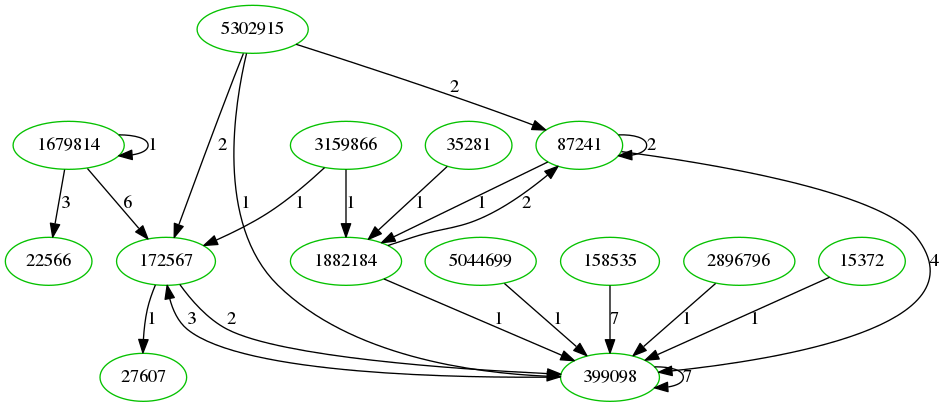

mean distance  8.601877708924683
Project name: hiyaoroshigo, project owner: matsueoss, ghtorrent id: 43818409


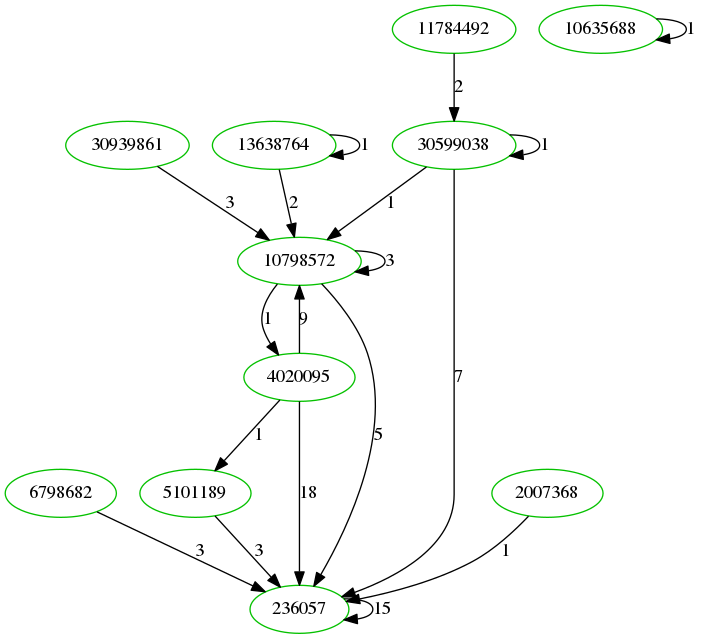

mean distance  8.605047245288805
Project name: p4c, project owner: p4lang, ghtorrent id: 52891428


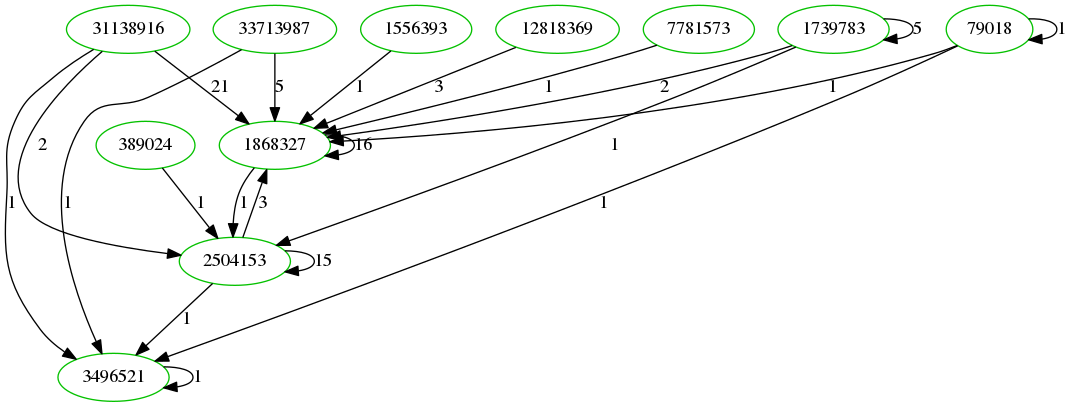

mean distance  8.615711188865257
Project name: travis-api, project owner: travis-ci, ghtorrent id: 59351


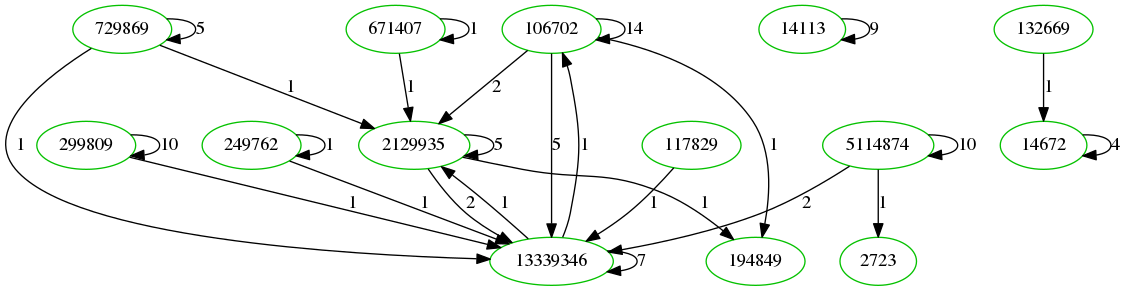

mean distance  8.644089198230063
Project name: scale, project owner: ngageoint, ghtorrent id: 28941838


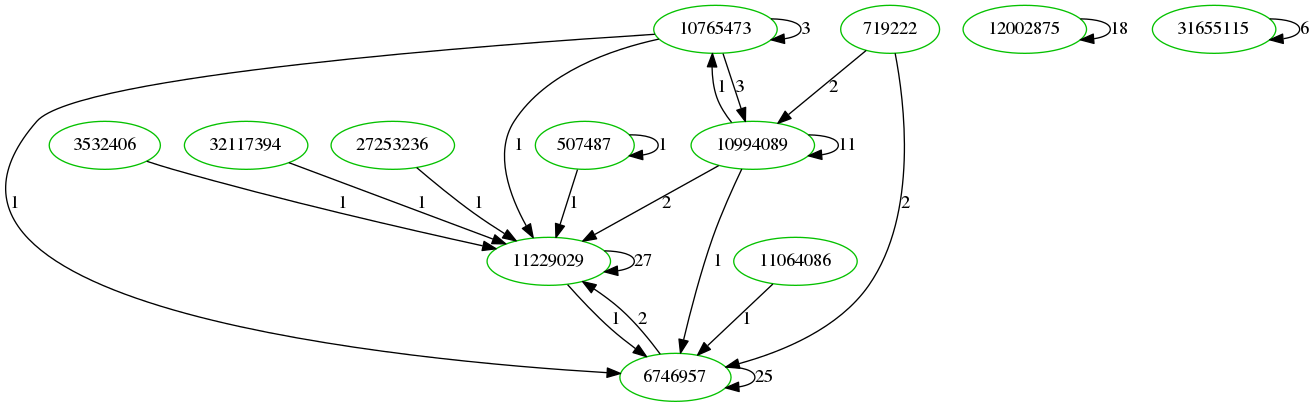

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  35.506906300702845
Project name: hoist, project owner: BonnyCI, ghtorrent id: 50439493


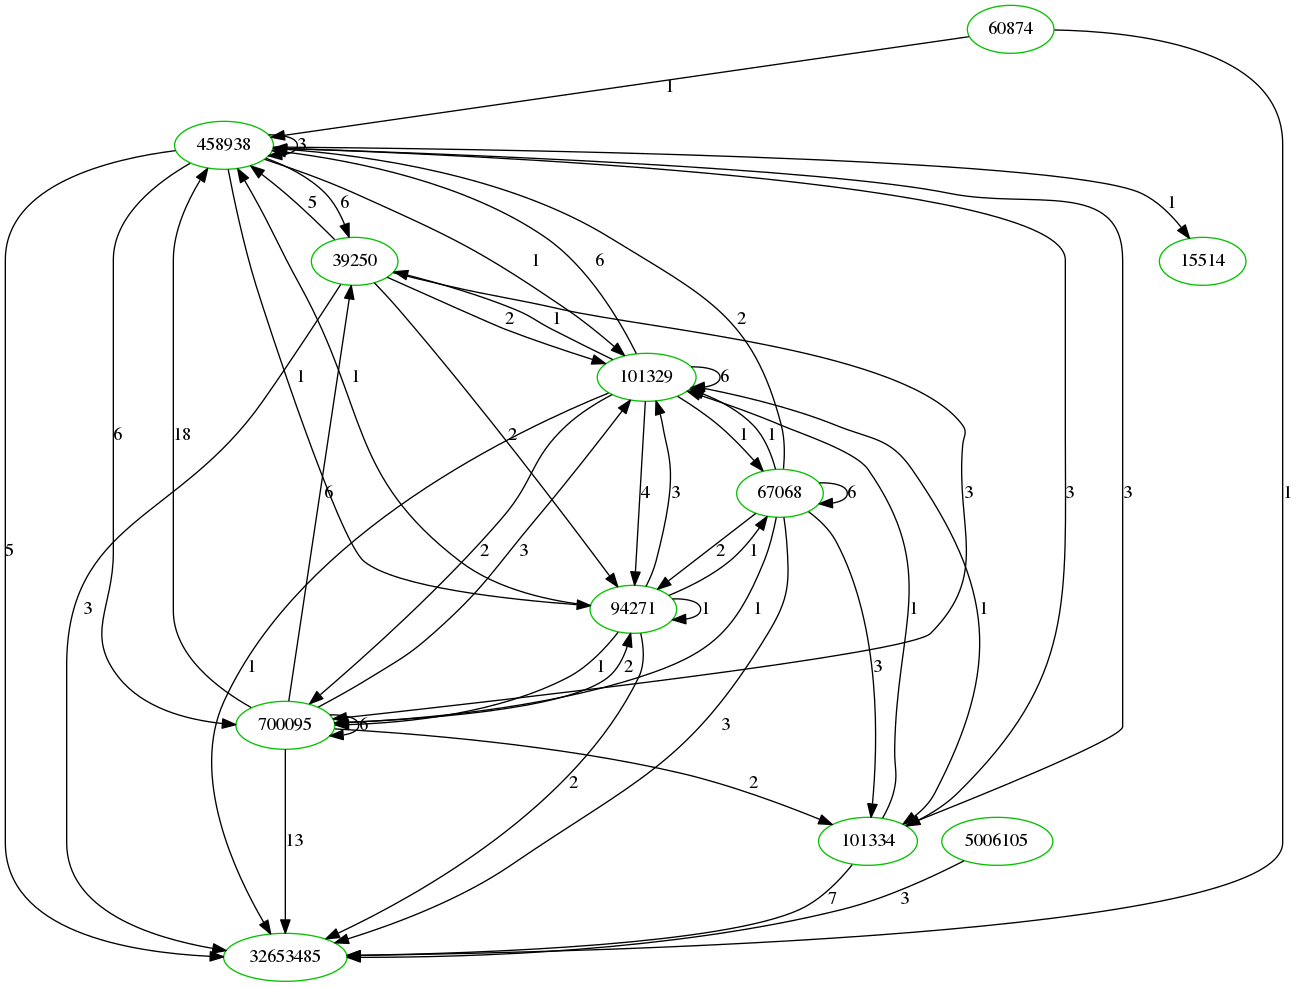

mean distance  36.26600310148948
Project name: h, project owner: hypothesis, ghtorrent id: 58572


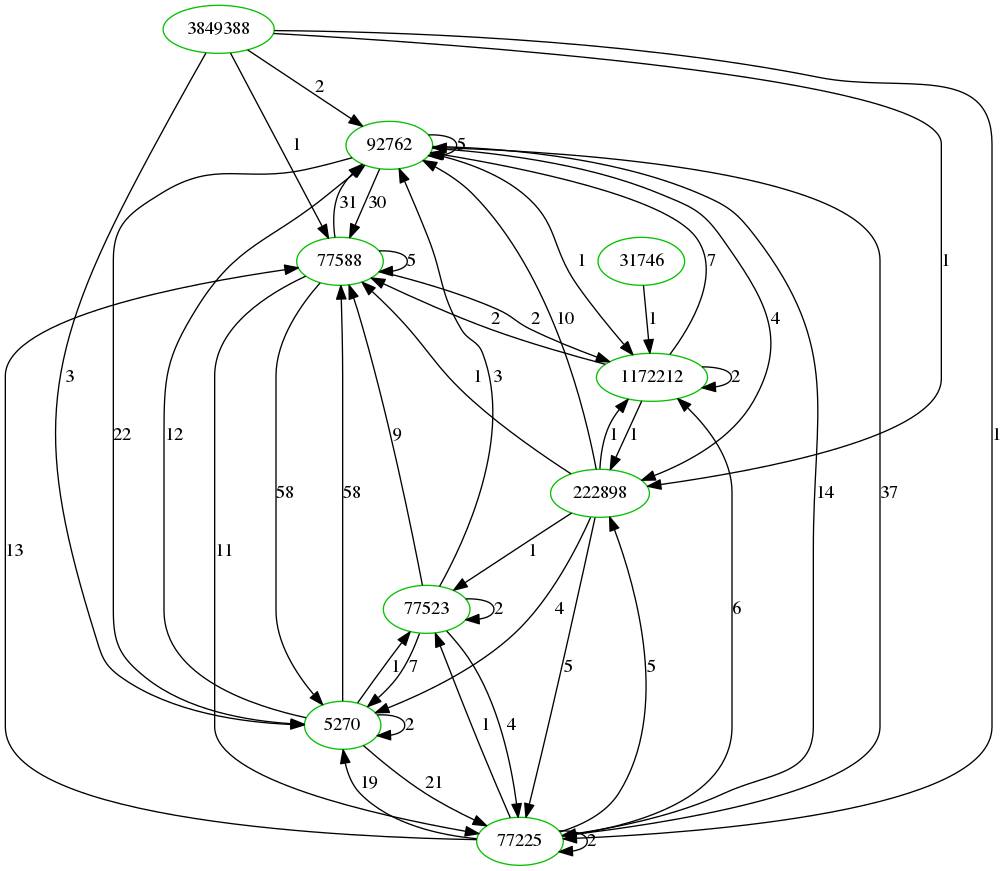

mean distance  37.97484155502557
Project name: fset-faststream-frontend, project owner: hmrc, ghtorrent id: 41128998


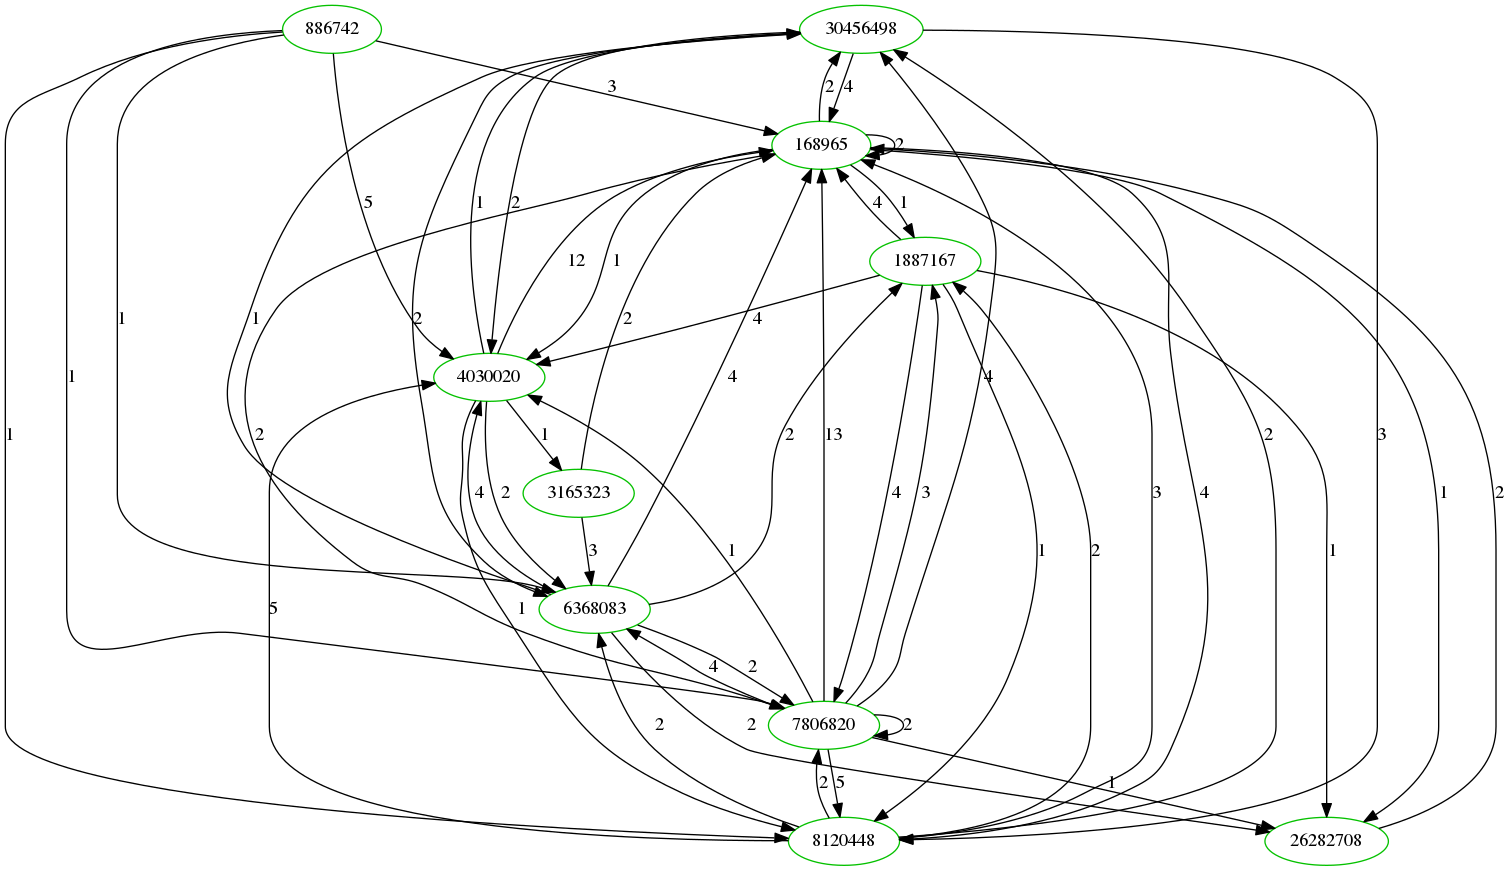

mean distance  40.22700613965017
Project name: www.ubuntu.com, project owner: ubuntudesign, ghtorrent id: 40797811


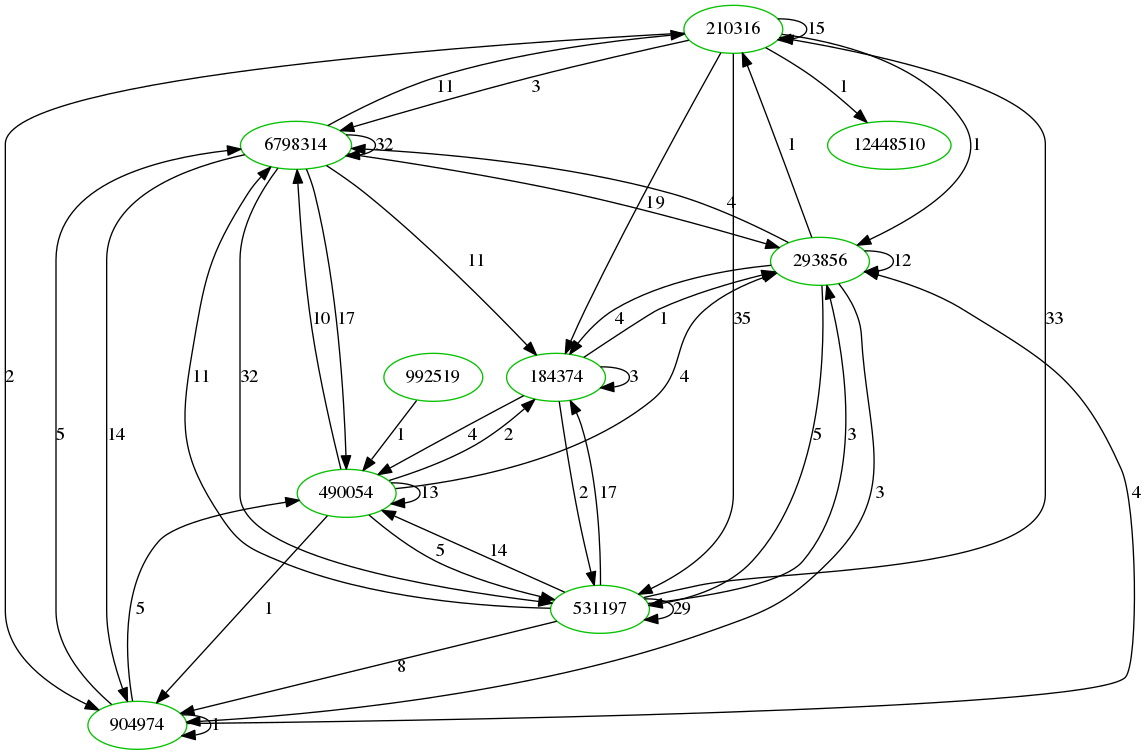

mean distance  43.637879427558595
Project name: calcentral, project owner: ets-berkeley-edu, ghtorrent id: 424371


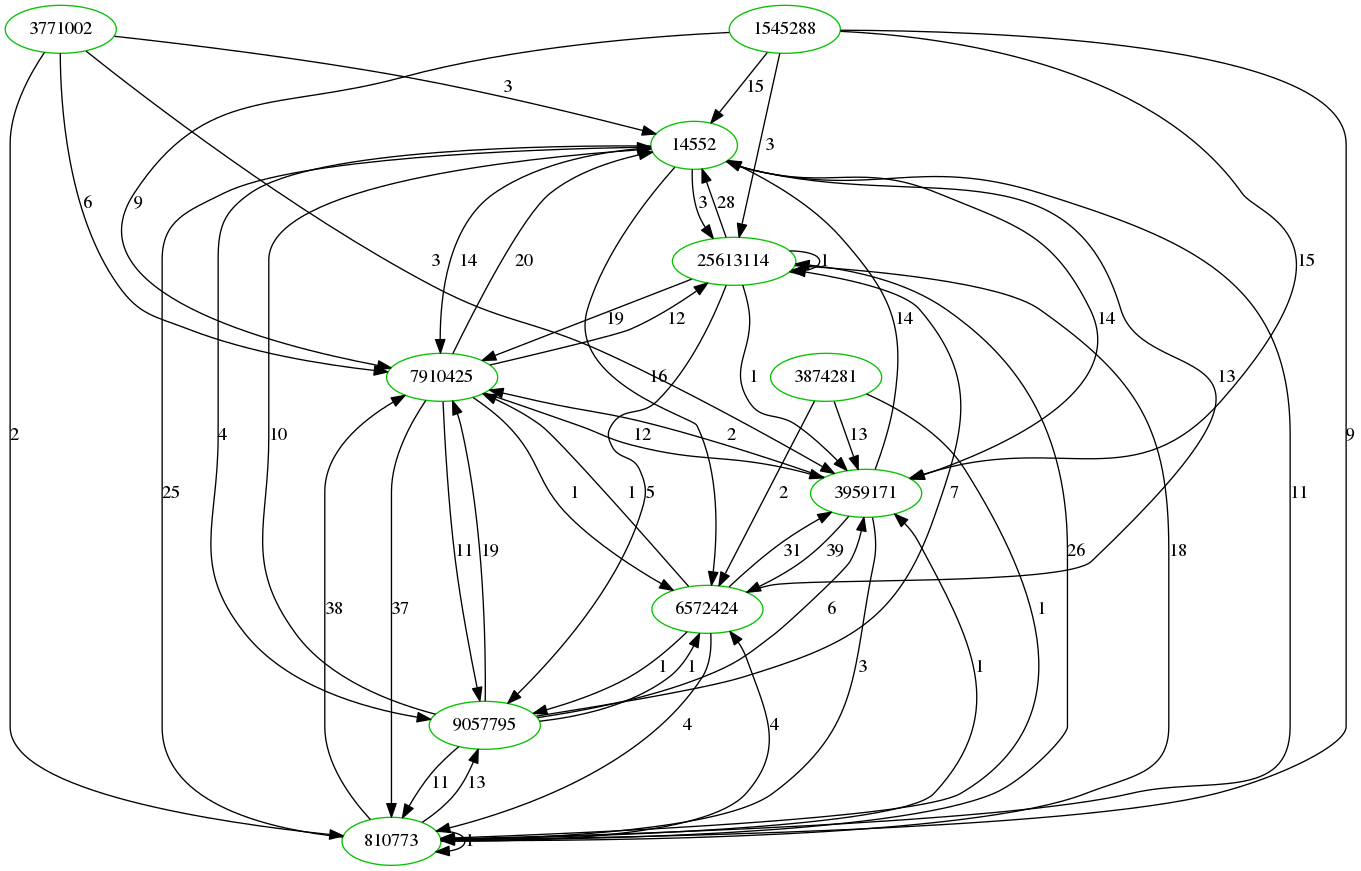

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [28]:
draw_most_representatives(cluster2s, feature_vecs_8to20, 5, 0, 0, colors[1])

### Explore cluster 3 (cluster1s)

To see what kind of projects are in the third cluster (cluster1s) we desplay the 10 projects that on average have the smallest distance to all other projects in the cluster.
Furthermore, the function below subsequently also displays the 10 projects that have the biggest distance to all other projects in the cluster. These are the projects on the periphery of the cluster.

This cluster seems to still possess a huge variety of different structures and we can not see a clear intuitive interpretation.
The commonality of the central projects and the projects on the periphery seems to be, that they do not fit in the other two clusters. Many projects seem to degenerate into several components

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  3.855668892502739
Project name: nativescript-background-http, project owner: NativeScript, ghtorrent id: 25181147


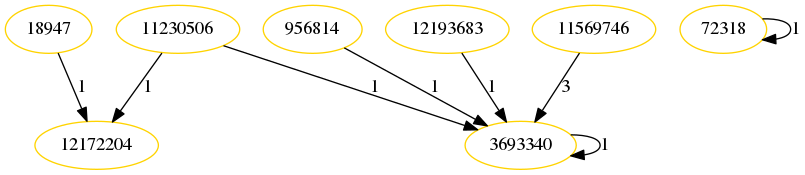

mean distance  3.863158792666167
Project name: proxmark3, project owner: Proxmark, ghtorrent id: 8618875


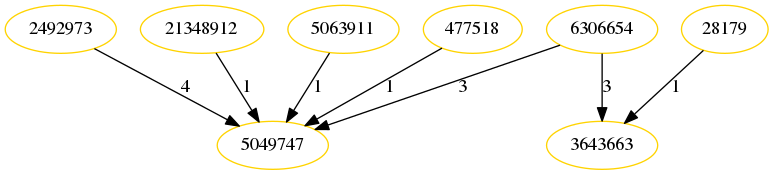

mean distance  3.863158792666167
Project name: ransack, project owner: activerecord-hackery, ghtorrent id: 6442229


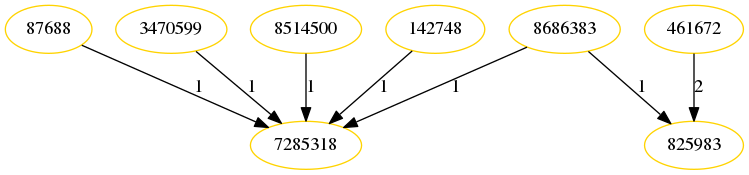

mean distance  3.863158792666167
Project name: HackCU2017, project owner: HackCU, ghtorrent id: 36851764


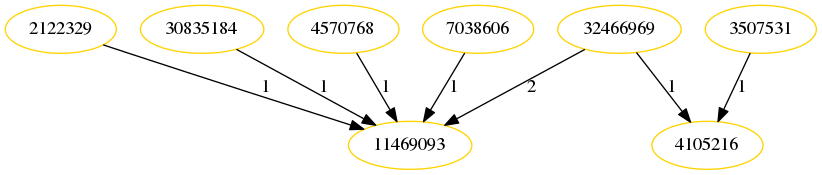

mean distance  3.8868562182028406
Project name: legion, project owner: StanfordLegion, ghtorrent id: 2939782


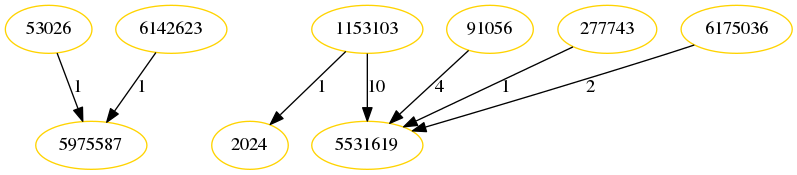

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  11.095286608972504
Project name: Common, project owner: aspnet, ghtorrent id: 16439239


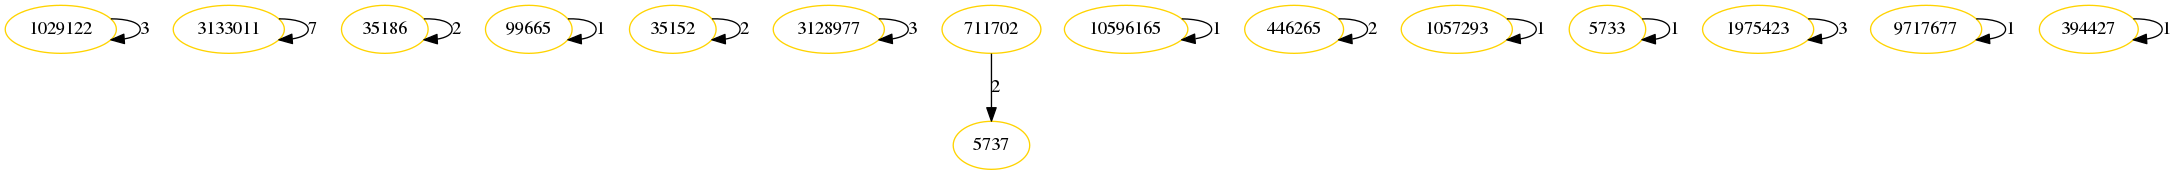

mean distance  11.83718855601104
Project name: dev-dec-19, project owner: githubteacher, ghtorrent id: 53019708


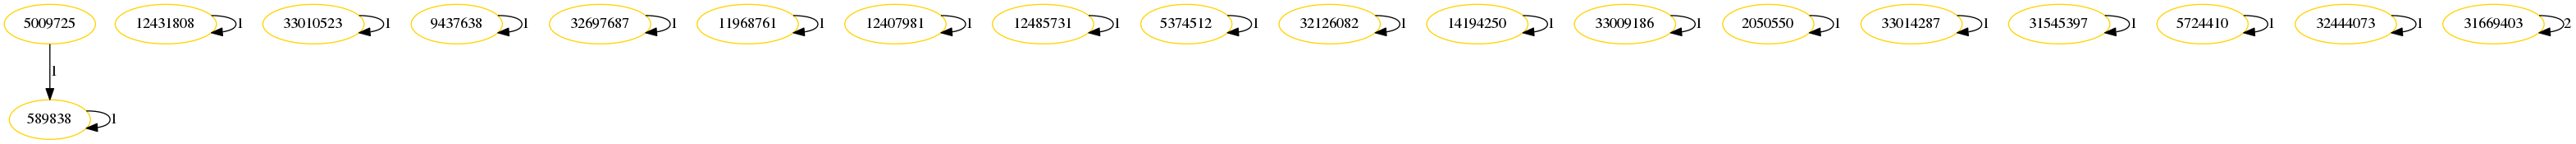

mean distance  12.52214330560871
Project name: docs-rabbitmq-staging, project owner: pivotal-cf, ghtorrent id: 6435067


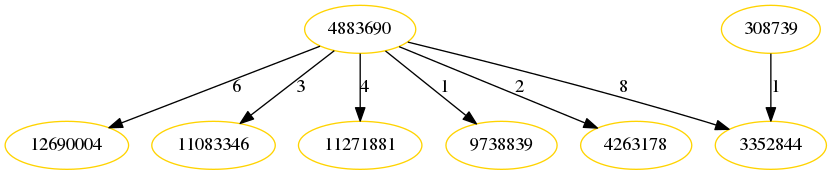

mean distance  12.85584854002957
Project name: oct-04-dev, project owner: githubteacher, ghtorrent id: 47472936


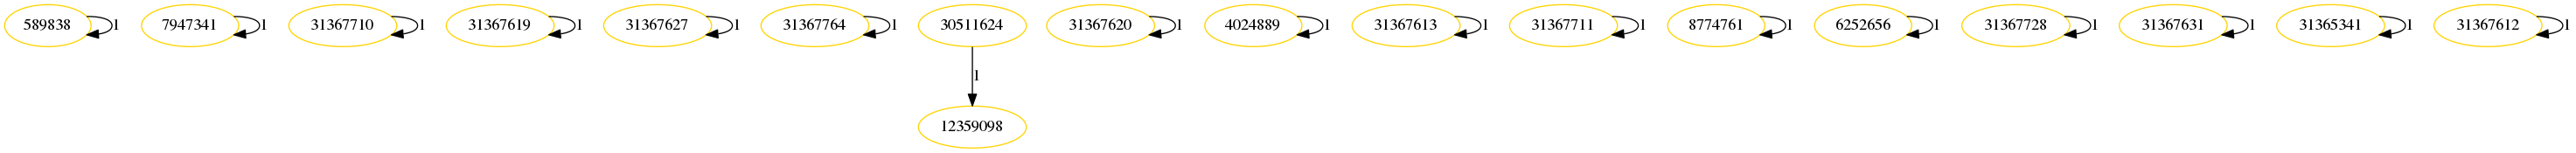

mean distance  14.630176823191764
Project name: fh-openshift-templates, project owner: feedhenry, ghtorrent id: 51412435


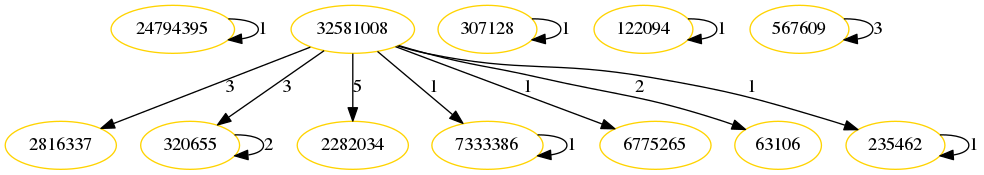

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [29]:
draw_most_representatives(cluster1s, feature_vecs_8to20, 5, 0, 0, colors[2])

### Second level clustering on cluster 3 (cluster1s)
Since cluster1s still shows a lot of variety in terms of network structures, we perform a second level clustering on this cluster.
We follow the same reasoning as before only on the subset of projects that belong to cluster 3 (cluster1s).

->  we create a similarity network in which similar projects are connected by a weighted tie that depends on the distance between projects. We introduce a treshold distance at which nodes do not have a tie anymore. We do not want projects that have a great distance to be connected. At the same time we do not want the cluster solution to depend explicitly on the treshold. We therefore vary the threshold and try to find a stable cluster solution. We vary the treshold starting roughly from the  mean distance between all project to two times the mean distance (i.e from 10 to 19). 

In [30]:
np.random.seed(seed=123)
no_partitions2=defaultdict(list)
partitions2={}
modularities2={}

nodes= cluster1s
Y=distance.pdist([feature_vecs_8to20[node] for node in nodes], 'seuclidean', V=varis)
for treshold in range(10,20,1):

    tuples=combinations(nodes,2)

    G=nx.Graph()

    G.add_weighted_edges_from([(*indeces,(treshold - dist)/treshold) for indeces, dist in zip(tuples,Y) if dist < treshold ])

    G_nodes=G.nodes
    for node in nodes:
        if node not in G_nodes:
            G.add_node(node)
    #compute the best partition
    
   
    for res in [(0.1*x+ 0.8) for x in range(7)]:
        try:
            partition1s = community.best_partition(G, resolution=res)
            modularity1s=community.modularity(partition1s, G, weight='weight')
            name="tresh" + str(treshold) + "-res-"+str(res)[:4]
            partitions2[name]=partition1s
            modularities2[name]=modularity1s
            no_partitions2[str(treshold)].append(len(set(partition1s.values())))
        except:
            print("fail")
            pass

In [31]:
pickle.dump(partitions2, open("data/partitions_level2", "wb"))
pickle.dump(modularities2, open("data/modularities_level2", "wb"))

In [32]:
partitions2 = pickle.load(open("data/partitions_level2", "rb"))
modularities2 = pickle.load(open("data/modularities_level2", "rb"))

# subcluster sizes

In [33]:
no_p_clean2=[]
no_singlets2=[]
for treshold in range(10,20,1):
    counts=[]
    singletsn=[]
    for res in [(0.1*x+0.8) for x in range(7)]:
        name="tresh" + str(treshold) + "-res-"+str(res)[:4]
        tp=partitions2[name]
        d = defaultdict(int)
        for k,v in tp.items():
            d[v]+=1

        count=0
        singlets=0
        for k,v in d.items():
            if v>20:
                count+=1
            else:
                singlets+=1
        counts.append(count)
        singletsn.append(singlets)
    no_p_clean2.append(counts)
    no_singlets2.append(singletsn)



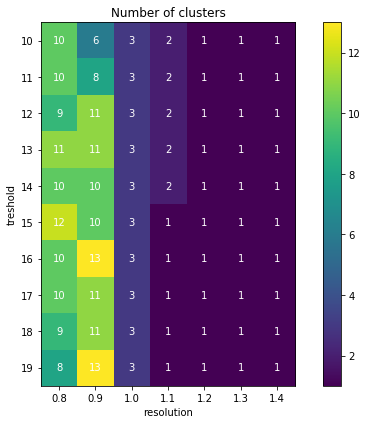

In [34]:
xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4']
yticks=['10','11', '12', '13', '14', '15', '16', '17', '18', '19']

dmat=np.array(no_p_clean2)

fig, ax = plt.subplots(figsize = (8,6))
im = ax.imshow(dmat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*dmat.nonzero()):
    ax.text(j, i, dmat[i, j], color='white', ha='center', va='center')

ax.set_title("Number of clusters")
plt.xlabel("resolution")
plt.ylabel("treshold")
fig.tight_layout()
plt.colorbar(im)
fig.savefig('clustermatrix.png', dpi=300)
plt.show()

# Stability of cluster solutions

To have a quantitative measure for the stability of the cluster solutions with respect to the treshold parameter we calculate
both the adjusted rand score and the adjusted mutual information for each pair of cluster solutions with the same resolution parameter. 

In [35]:
nodes = cluster1s
resolutions = [(0.1*x+0.8) for x in range(4)] #we only look at r<1.1 because for r>=1.2 we only get a single cluster
avg_ari = []
ari_matrices = []
avg_ami = []
ami_matrices = []

for res in resolutions:
    names=["tresh" + str(treshold) + "-res-"+str(res)[:4] for treshold in range(10,20,1)]
    ari_matrix=[]
    ami_matrix=[]
    for i in range(len(names)):
        arr_ari = []
        arr_ami = []
        for j in range(len(names)):
            p1 = partitions2[names[i]]
            p2 = partitions2[names[j]]
            ari = adjusted_rand_score([p1[n] for n in nodes], [p2[n] for n in nodes])
            ami = adjusted_mutual_info_score([p1[n] for n in nodes], [p2[n] for n in nodes])
            arr_ari.append(ari)       
            arr_ami.append(ami)
        ari_matrix.append(arr_ari)
        ami_matrix.append(arr_ami)
    ari_matrices.append(ari_matrix)
    ami_matrices.append(ami_matrix)
    avg_ari.append(np.mean(ari_matrix))
    avg_ami.append(np.mean(ami_matrix))
    

/home/trurl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Below we plot the average adjusted rand index and the average adjusted mutual information for all pairs of partitions from the cluster solutions with the same resolution parameter. We clearly see a maximum in partition stability for the cluster solutions with resolution parameter 1.0, where the obtained partitions show the highes congruence for different tresholds.

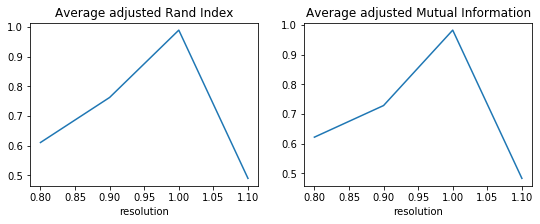

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(resolutions, avg_ari)
axs[0].set_title("Average adjusted Rand Index")
axs[0].set_xlabel("resolution")

axs[1].plot(resolutions, avg_ami)
axs[1].set_title("Average adjusted Mutual Information")
axs[1].set_xlabel("resolution")
plt.show()

Again we choose the resolution parameter 1.0 since there is the first clear plateau and it has a clear meaning with classic modularity. Subsequently we proceed as before and vary the tresholds values to clean the clusters and only keep the ones that are consistently classified in the same cluster.

# modularity

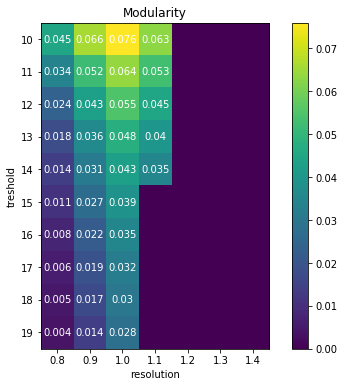

In [37]:

modularities_plot=[]
for treshold in range(10,20,1):
    m_arr = []
    for res in [(0.1*x+0.8) for x in range(7)]:
        name="tresh" + str(treshold) + "-res-"+str(res)[:4]
        m = modularities2[name]
        m_arr.append(m)
    modularities_plot.append(m_arr)

modularities_coeff=np.round(np.array(modularities_plot),3)

fig, ax = plt.subplots(figsize = (8,6) )
im = ax.imshow(modularities_coeff)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*modularities_coeff.nonzero()):
    ax.text(j, i, modularities_coeff[i, j], color='white', fontsize = 10, ha='center', va='center')

plt.colorbar(im)
ax.set_title("Modularity")
plt.xlabel("resolution")
plt.ylabel("treshold")
plt.show()

# Dunn's index

In [38]:
dunns_index_centroids_dict2 = {}
for key in partitions2:
    partition = partitions2[key]
    if len(np.unique(list(partition.values())))>1: #check that partition has at least two clusters
        nodes = list(partition.keys())
        vecs=[feature_vecs_8to20[n] for n in nodes]
        labels = [partition[n] for n in nodes]
        di = dunn_centroids(labels, vecs, min_cluster_size = 5)    
        dunns_index_centroids_dict2[key]=di

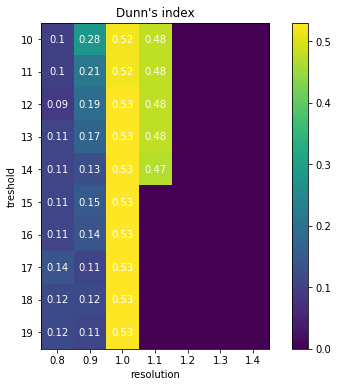

In [39]:

xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4']
yticks=['10', '11', '12','13', '14', '15', '16', '17', '18', '19']

dunns_index_centroids_plot=[]
for treshold in range(10,20,1):
    m_arr = []
    for res in [(0.1*x+0.8) for x in range(7)]:
        name="tresh" + str(treshold) + "-res-"+str(res)[:4]
        try:
            m = dunns_index_centroids_dict2[name]
        except:
            m = 0
        m_arr.append(m)
    dunns_index_centroids_plot.append(m_arr)

dunns_index_centroids_coeff=np.round(np.array(dunns_index_centroids_plot),2)

fig, ax = plt.subplots(figsize = (8,6) )
im = ax.imshow(dunns_index_centroids_coeff)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*dunns_index_centroids_coeff.nonzero()):
    ax.text(j, i, dunns_index_centroids_coeff[i, j], color='white', fontsize = 10, ha='center', va='center')
plt.colorbar(im)

ax.set_title("Dunn's index")
plt.xlabel("resolution")
plt.ylabel("treshold")
plt.show()

# connectedness

In [40]:
nodes = list(cluster1s)
dists=distance.pdist([feature_vecs_8to20[node] for node in nodes], 'seuclidean', V=varis)
dists = distance.squareform(dists)

In [41]:
sorted_dists = [np.argsort(dists[i]) for i in range(len(nodes))]
sorted_dists = [sorted_dists[i][sorted_dists[i]!=i] for i in range(len(nodes))] #remove distance to itself


In [42]:
index_dict = {node:i for i,node in enumerate(nodes)} 

In [43]:
def connectedness(partition, l=5):
    conn = 0
    for node in partition:
        node_cl = partition[node]
        ind = index_dict[node]
        neighbors_idxs = sorted_dists[index_dict[node]][:l]
        for j,neighbor_idx in enumerate(neighbors_idxs):
            neighbor = nodes[neighbor_idx]
            if partition[neighbor]!=node_cl:
                conn+= 1/(j+1)
    return conn/len(partition)

In [44]:
connectedness_dict2 = {}
for key in partitions2:
    c = connectedness(partitions2[key],5)
    connectedness_dict2[key]=c

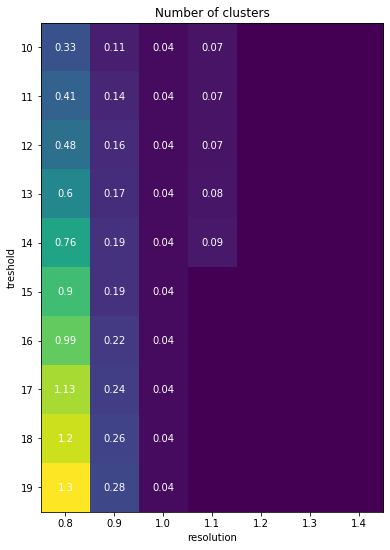

In [45]:

xticks=['0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4']
yticks=['10', '11', '12','13', '14', '15', '16', '17', '18', '19']

connectivities_plot=[]
for treshold in range(10,20,1):
    m_arr = []
    for res in [(0.1*x+0.8) for x in range(7)]:
        name="tresh" + str(treshold) + "-res-"+str(res)[:4]
        m = connectedness_dict2[name]
        m_arr.append(m)
    connectivities_plot.append(m_arr)

connectivities_coeff=np.round(np.array(connectivities_plot),2)

fig, ax = plt.subplots(figsize = (12,9) )
im = ax.imshow(connectivities_coeff)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xticks)))
ax.set_yticks(np.arange(len(yticks)))
# ... and label them with the respective list entries
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)


# Loop over data dimensions and create text annotations.
for i, j in zip(*connectivities_coeff.nonzero()):
    ax.text(j, i, connectivities_coeff[i, j], color='white', fontsize = 10, ha='center', va='center')

ax.set_title("Number of clusters")
plt.xlabel("resolution")
plt.ylabel("treshold")
plt.show()

In [46]:
compare_ps=[ 'tresh10-res-1.0', 'tresh11-res-1.0', 'tresh12-res-1.0', 'tresh13-res-1.0', 'tresh14-res-1.0', 'tresh15-res-1.0', 'tresh16-res-1.0', 'tresh17-res-1.0', 'tresh18-res-1.0', 'tresh19-res-1.0']
for k in compare_ps:
    print(k)
    p=partitions2[k]
    cluster1s0=[x for x in p if p[x]==0]
    cluster1s1=[x for x in p if p[x]==1]
    cluster1s2=[x for x in p if p[x]==2]
    print("cluster 0: ", len(cluster1s0))
    print("cluster 1: ", len(cluster1s1))
    print("cluster 2: ", len(cluster1s2))
    print("\n")

tresh10-res-1.0
cluster 0:  527
cluster 1:  402
cluster 2:  543


tresh11-res-1.0
cluster 0:  527
cluster 1:  399
cluster 2:  546


tresh12-res-1.0
cluster 0:  527
cluster 1:  393
cluster 2:  552


tresh13-res-1.0
cluster 0:  527
cluster 1:  387
cluster 2:  558


tresh14-res-1.0
cluster 0:  527
cluster 1:  386
cluster 2:  559


tresh15-res-1.0
cluster 0:  527
cluster 1:  386
cluster 2:  559


tresh16-res-1.0
cluster 0:  527
cluster 1:  386
cluster 2:  559


tresh17-res-1.0
cluster 0:  527
cluster 1:  386
cluster 2:  559


tresh18-res-1.0
cluster 0:  527
cluster 1:  386
cluster 2:  559


tresh19-res-1.0
cluster 0:  527
cluster 1:  386
cluster 2:  559




In [47]:
cluster1s0s=set(cluster1s0)
cluster1s1s=set(cluster1s1)
cluster1s2s=set(cluster1s2)
for key in compare_ps:
    partition=partitions2[key]
    cluster0=[x for x in partition if partition[x]==0]
    cluster1=[x for x in partition if partition[x]==1]
    cluster2=[x for x in partition if partition[x]==2]
    cluster1s0s=cluster1s0s.intersection(set(cluster0))
    cluster1s1s=cluster1s1s.intersection(set(cluster1))
    cluster1s2s=cluster1s2s.intersection(set(cluster2))
print("cluster 0: ", len(cluster1s0s))
print("cluster 1: ", len(cluster1s1s))
print("cluster 2: ", len(cluster1s2s))

cluster 0:  527
cluster 1:  385
cluster 2:  542


In [48]:
garbage=set(partition.keys()).difference(cluster1s0s,cluster1s1s,cluster1s2s)

In [49]:
len(garbage)

18

### Draw clusters 3 to 5

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  1.8648742472333366
Project name: ohpc, project owner: openhpc, ghtorrent id: 28718415


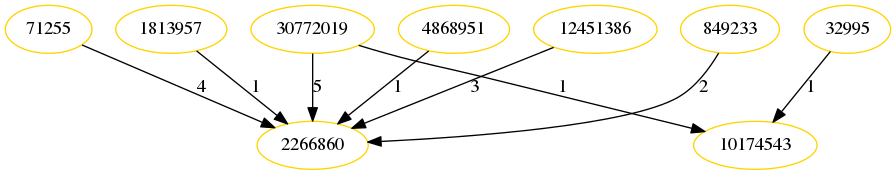

mean distance  1.8648742472333368
Project name: firstHackDallas-Submissions, project owner: firsthackdallas, ghtorrent id: 50038064


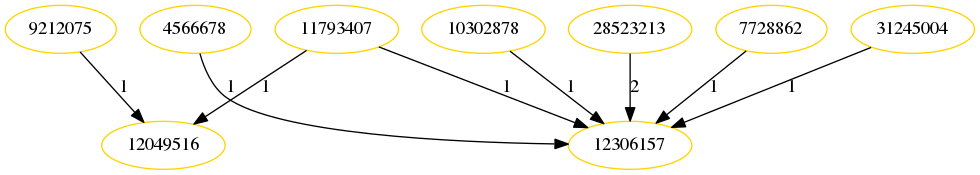

mean distance  1.8648742472333368
Project name: subtitleedit, project owner: SubtitleEdit, ghtorrent id: 7744539


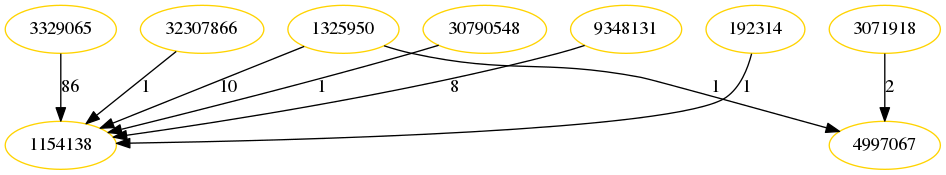

mean distance  1.8648742472333368
Project name: daia-config, project owner: gbv, ghtorrent id: 4330736


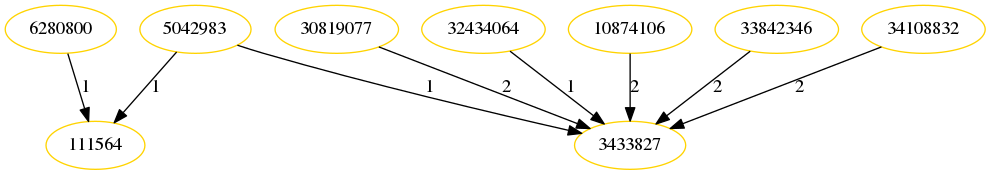

mean distance  1.8949723370271416
Project name: location-plugin, project owner: rainlab, ghtorrent id: 19833548


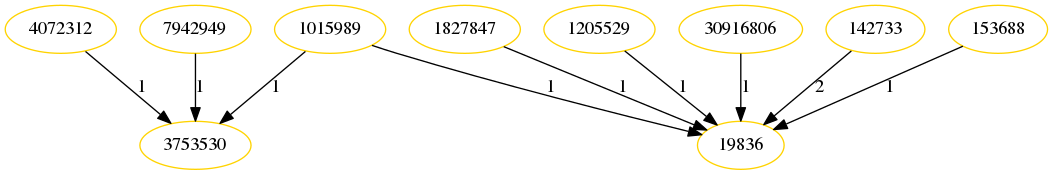

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  5.3343540886942264
Project name: hacklab-almeria.github.io, project owner: HackLab-Almeria, ghtorrent id: 16535577


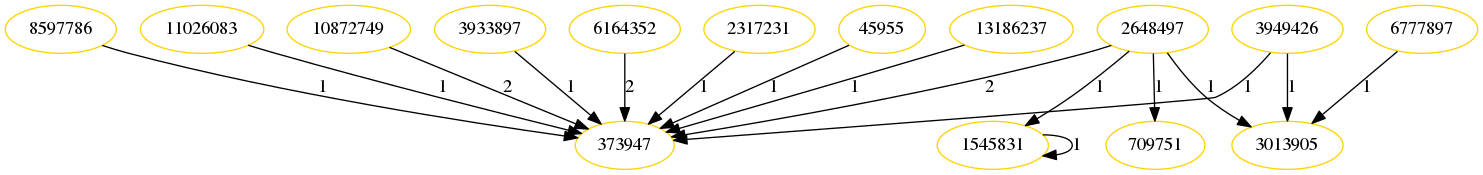

mean distance  5.353766491478219
Project name: ensembl-webcode, project owner: Ensembl, ghtorrent id: 6977976


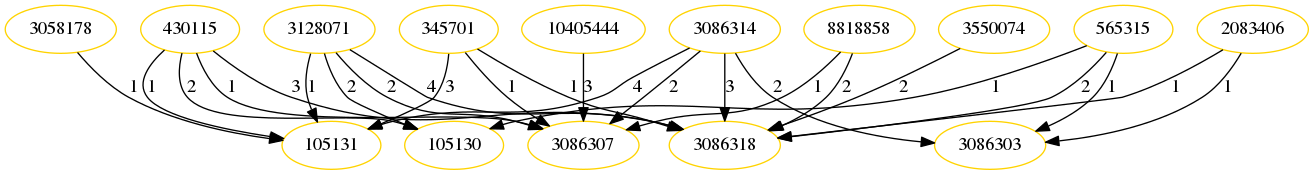

mean distance  5.7061559911695285
Project name: dl-ui, project owner: danliris, ghtorrent id: 42787101


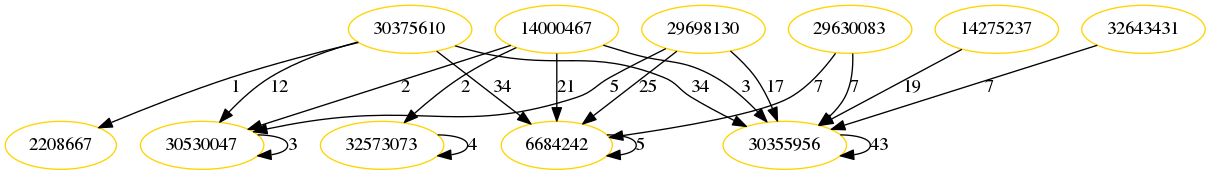

mean distance  5.72716570274067
Project name: oe-alliance-plugins, project owner: oe-alliance, ghtorrent id: 123568


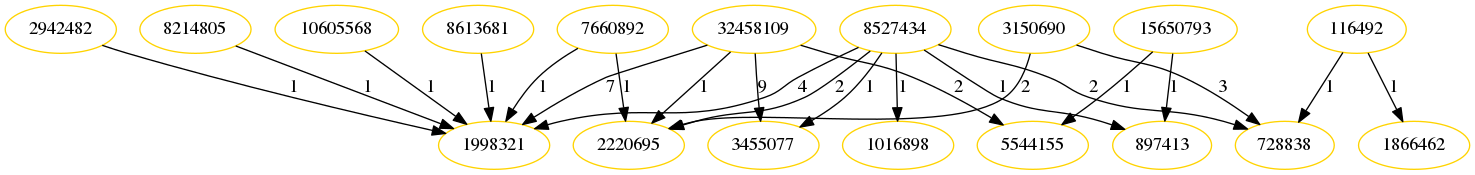

mean distance  6.552627246433159
Project name: enigma2, project owner: openatv, ghtorrent id: 3410497


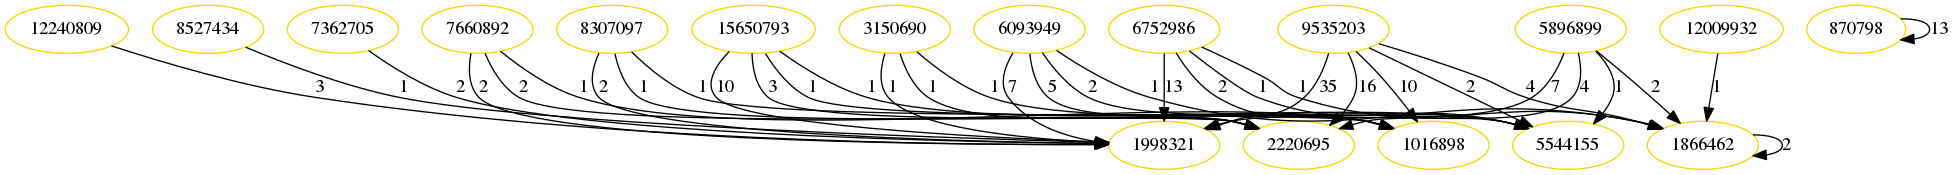

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [50]:
draw_most_representatives(cluster1s2s, feature_vecs_8to20, 5, 0, 0, colors[2])

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  3.9047194862277763
Project name: Platform-CI, project owner: RHQE, ghtorrent id: 33806433


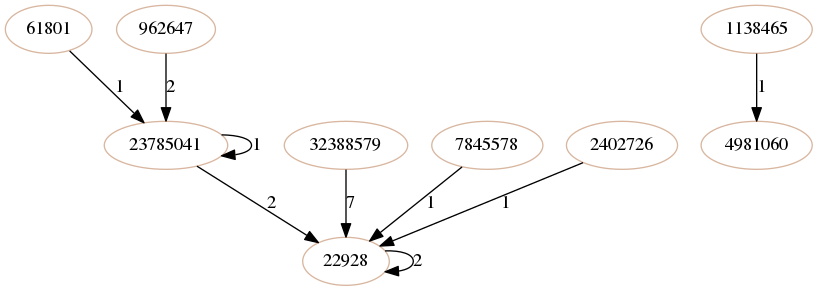

mean distance  3.9430899200368836
Project name: linux-sgx, project owner: 01org, ghtorrent id: 39882805


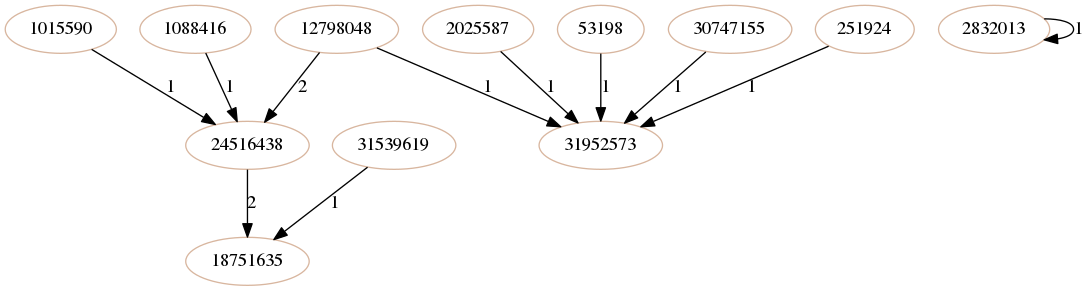

mean distance  3.991197940275473
Project name: Magneticraft, project owner: Magneticraft-Team, ghtorrent id: 30965635


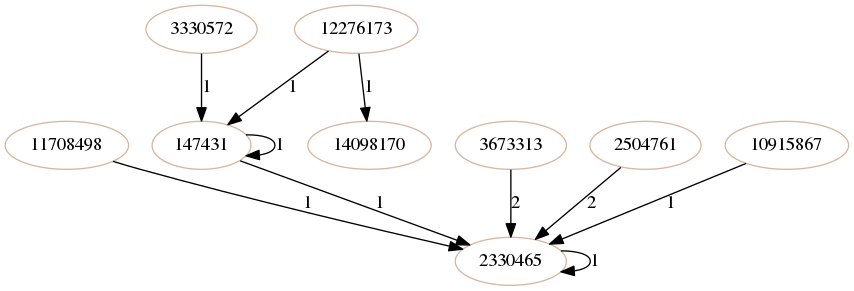

mean distance  4.017047782701024
Project name: fedy, project owner: folkswithhats, ghtorrent id: 22281442


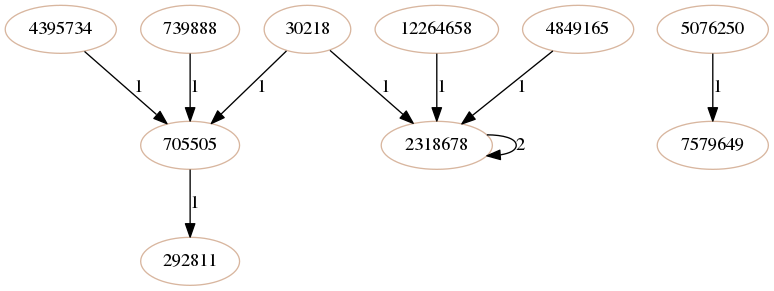

mean distance  4.0284423077024165
Project name: kafka-connect-hdfs, project owner: confluentinc, ghtorrent id: 28852302


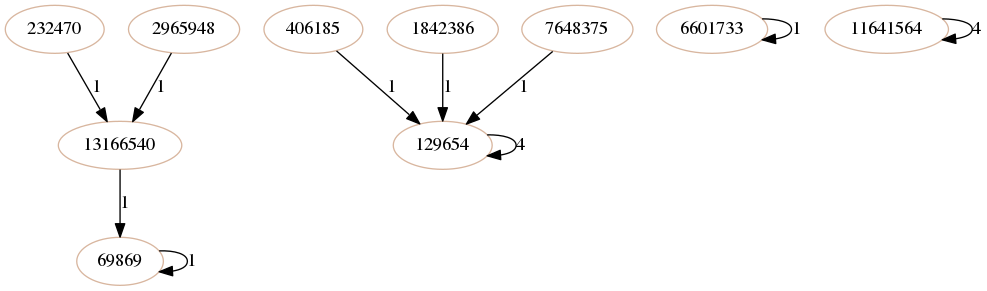

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  8.431729087599956
Project name: concourse-tutorial, project owner: StarkAndWayne, ghtorrent id: 19756096


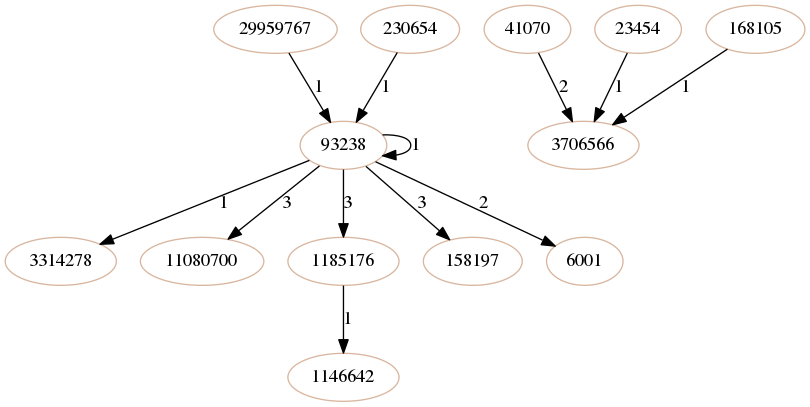

mean distance  8.483418356983197
Project name: ircv3.github.io, project owner: ircv3, ghtorrent id: 19273658


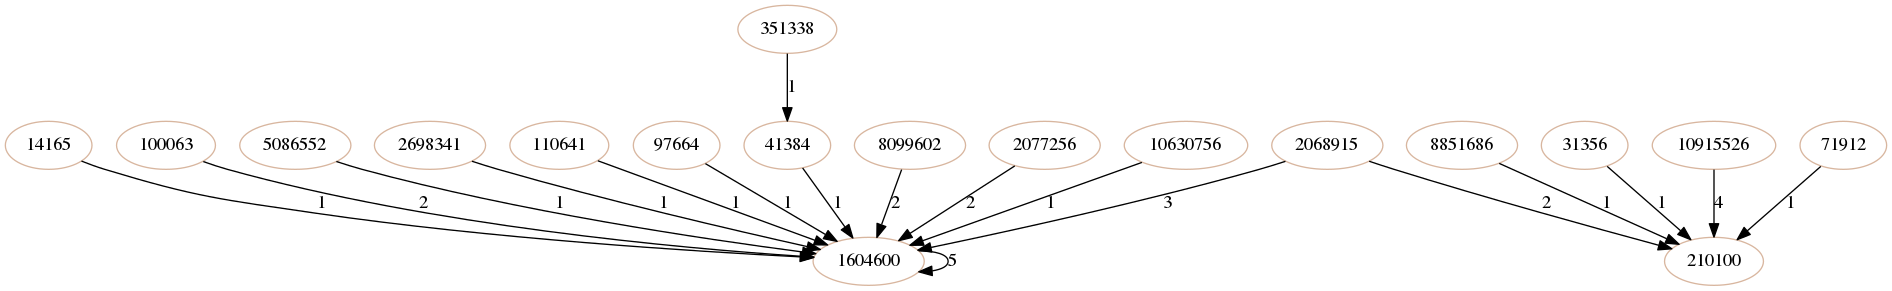

mean distance  8.793949263165622
Project name: maslow, project owner: alphagov, ghtorrent id: 5640587


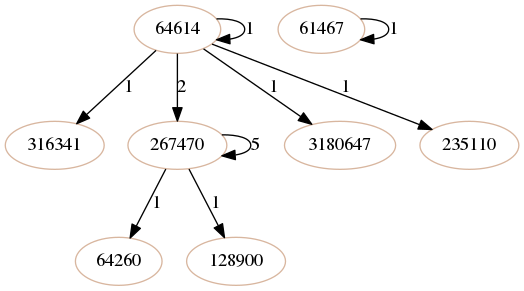

mean distance  8.951848074898445
Project name: github-tutorial, project owner: SeNSE-lab, ghtorrent id: 56402493


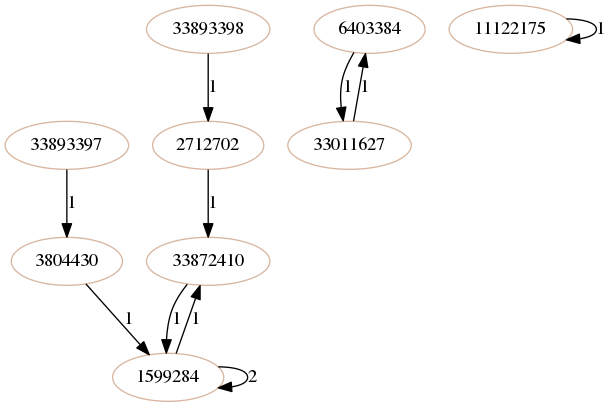

mean distance  9.417754432044356
Project name: devs-september, project owner: githubteacher, ghtorrent id: 45268976


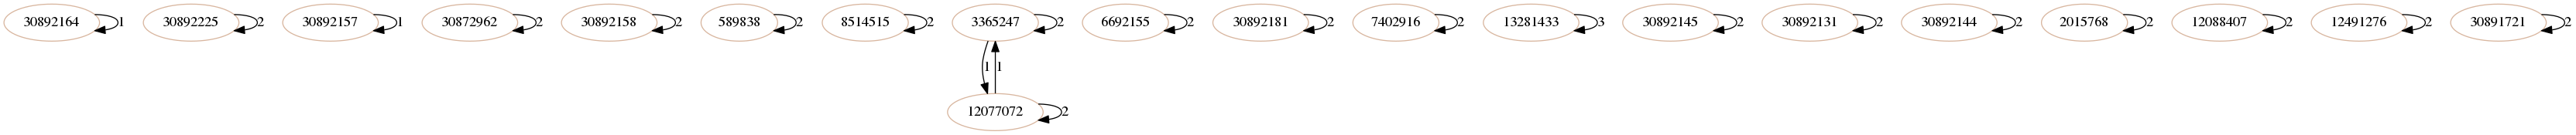

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [51]:
draw_most_representatives(cluster1s0s, feature_vecs_8to20, 5, 0, 0, colors[3])

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  3.3877801243669237
Project name: hazelcast-code-samples, project owner: hazelcast, ghtorrent id: 10304631


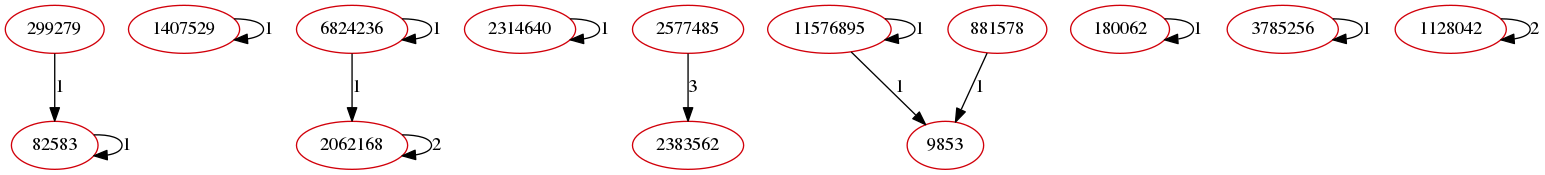

mean distance  3.3967992164504404
Project name: strong-error-handler, project owner: strongloop, ghtorrent id: 36892254


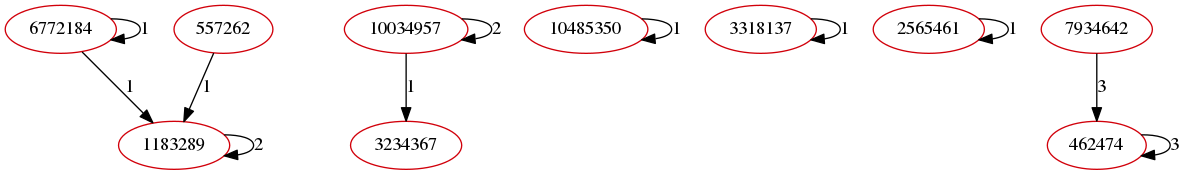

mean distance  3.3998526399611313
Project name: sentry-plugins, project owner: getsentry, ghtorrent id: 42885683


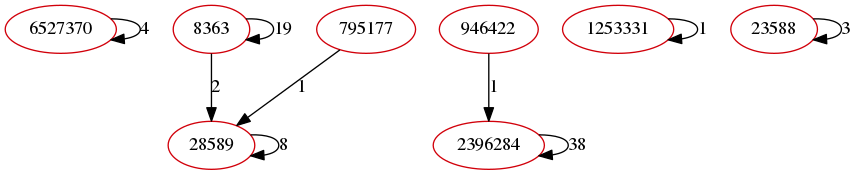

mean distance  3.407817674123078
Project name: docker-containers, project owner: mesosphere, ghtorrent id: 11383488


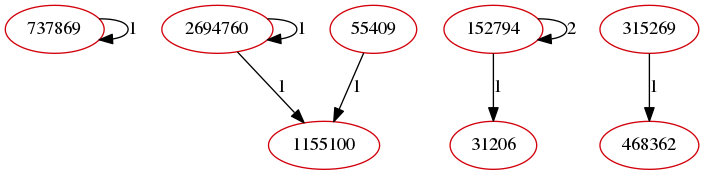

mean distance  3.407881587318228
Project name: ember-frost-popover, project owner: ciena-frost, ghtorrent id: 34835314


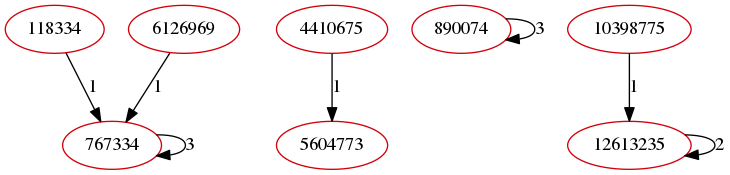

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  9.853005930937542
Project name: Common, project owner: aspnet, ghtorrent id: 16439239


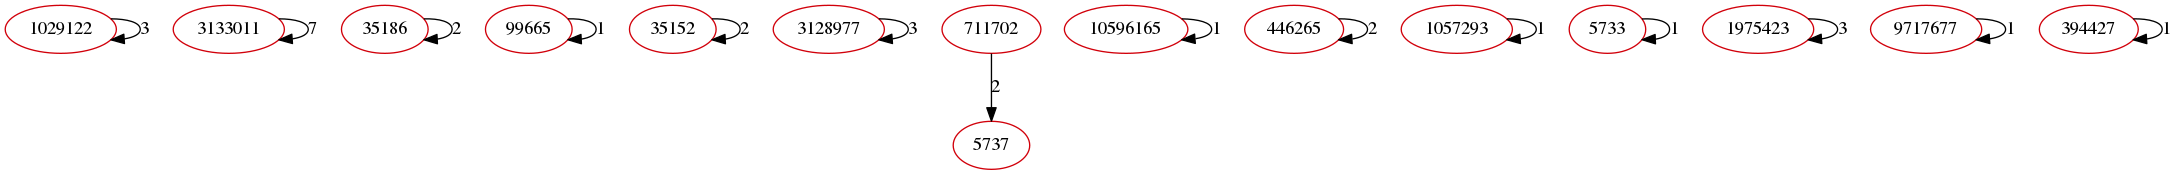

mean distance  10.662191501634197
Project name: dev-dec-19, project owner: githubteacher, ghtorrent id: 53019708


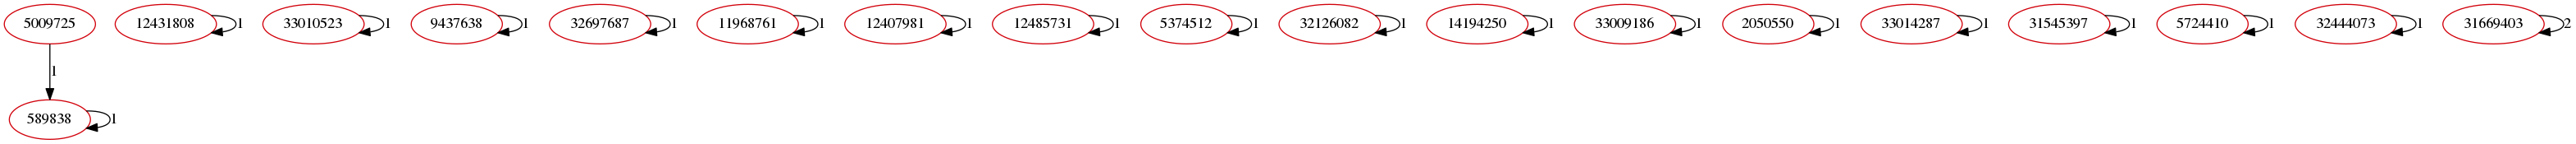

mean distance  11.743447662677042
Project name: oct-04-dev, project owner: githubteacher, ghtorrent id: 47472936


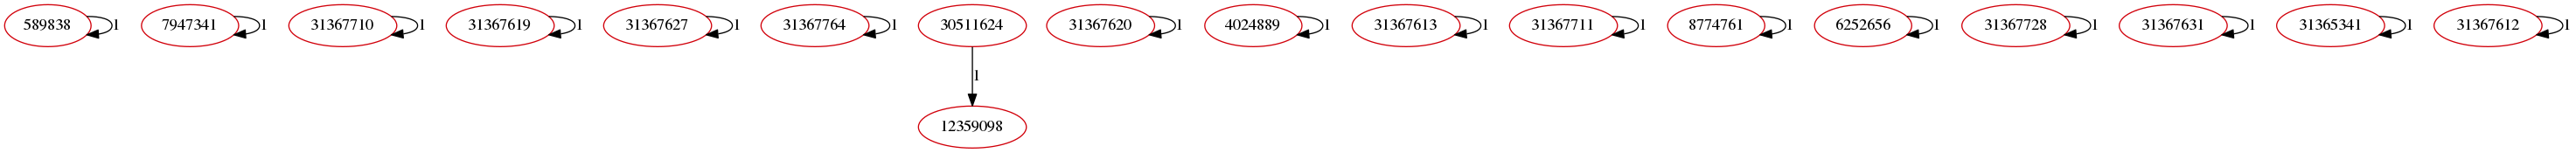

mean distance  11.893804746441646
Project name: docs-rabbitmq-staging, project owner: pivotal-cf, ghtorrent id: 6435067


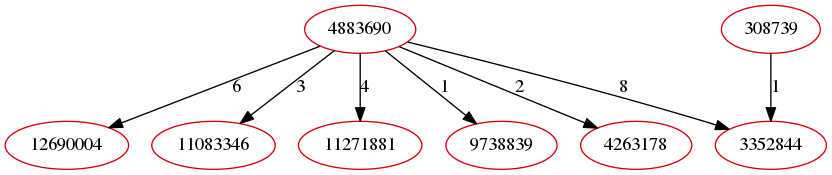

mean distance  13.877667825198678
Project name: fh-openshift-templates, project owner: feedhenry, ghtorrent id: 51412435


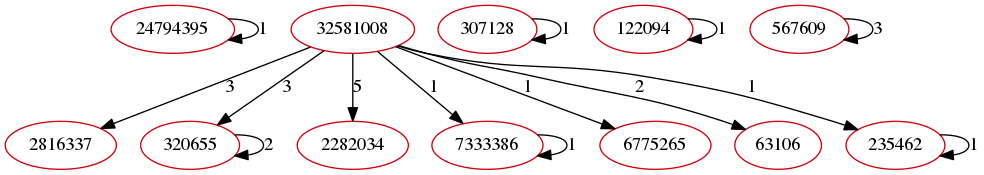

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [52]:
draw_most_representatives(cluster1s1s, feature_vecs_8to20, 5, 0, 0, colors[4])

In [53]:
final_partition={}
for node in cluster0s:
    final_partition[node]=0

for node in cluster2s:
    final_partition[node]=1

for node in cluster1s2s:
    final_partition[node]=2
    
for node in cluster1s0s:
    final_partition[node]=3

for node in cluster1s1s:
    final_partition[node]=4




In [54]:
pickle.dump(final_partition, open("data/final_partition", "wb"))

In [55]:
final_partition = pickle.load(open("data/final_partition", "rb"))

 # Principal component analysis of clusters
 This is a sanity check and serves to visualize the clusters in 2D. Projects of a cluster should be in the same area which they clearly are. Although this is just in 2 dimensions, we see that cluster 2, which consists of the complex projects seems to be the most widely spread, which is why Dunn's index is bounded by it.

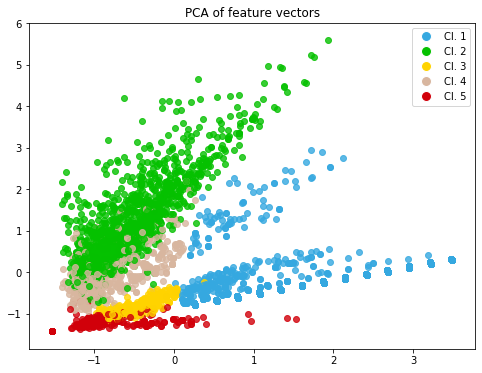

In [56]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

clusters = defaultdict(list)

for k,v in final_partition.items():
    clusters[v].append(k)
keys=[]
fvecs=[]
items= list(feature_vecs_8to20.items()) # List of tuples
random.shuffle(items)
for key,fvec in items:
    keys.append(key)
    fvecs.append(fvec)

pca = PCA(n_components=2, whiten=True)
X_r = pca.fit(fvecs).transform(fvecs)


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cl. ' + str(i+1), markerfacecolor=colors[i], markersize=10) for i in range(5)]

plt.figure(figsize = (8,6) )
plt.title("PCA of feature vectors")
for i,x in enumerate(X_r):
    if keys[i] in final_partition.keys():
        plt.scatter(x[0], x[1], color=colors[final_partition[keys[i]]], alpha=.8)
plt.legend(loc='best', shadow=False, handles = legend_elements)
plt.show()


# Sizes of final clusters

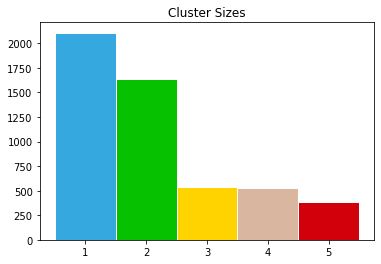

In [57]:
fig, ax = plt.subplots()
N, bins, patches = ax.hist([x+1 for x in list(final_partition.values())],bins=[x-0.5 for x in range(1, len(set(final_partition.values()))+2)],  edgecolor='white', linewidth=1)
for i in range(0,5):
    patches[i].set_facecolor(colors[i])
plt.title("Cluster Sizes")
plt.show()

# Feature distributions

In [58]:
from matplotlib import rc
import math
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mp.rcParams['xtick.labelsize'] = 15
mp.rcParams['ytick.labelsize'] = 15
rc('text', usetex=True)

# calculate distributions of feature vectors for partition
def get_feature_dist(partition, cluster_n, feature_n):
    id_list=[key for key in partition if partition[key]==cluster_n]
    feature_dist=[]
    for id_ in id_list:
        feature_dist.append(feature_vecs_8to20[id_][feature_n])
    return feature_dist

In [59]:
#Labels for netsimile feature vectors - and define plotranges 
feature_labels=[r"$d_{i}^+$", r"$d_{i}^-$",  r"$c_i$", r"$\overline{d^-_{N(i)^+}}$", r"$\overline{d^+_{N(i)^+}}$", r"$\overline{d^-_{N(i)^-}}$",r"$\overline{d^+_{N(i)^-}}$", r"$\overline{c_{N(i)^-}}$", r"$\overline{c_{N(i)^+}}$",r"$|E_{ego(i)^-}|$", r"$|E_{ego(i)^+}|$", r"$r_i$"]
plot_ranges=[(0,100), (0,0.5),(0,100),(0,0.4),(0,100), (0,50),(0,100),(0,100), (0,0.5),(0,100),(0,0.4),(0,120), (0,50),(0,100),(0,60), (0,0.3), (0,50), (0,0.2), (0,50), (0,30), (0,50), (-3,6),(0,6), (-5,5), (0,6), (-5,5),(-5,5), (-5,5), (0,20), (0,10), (0,20), (0,20), (0,30), (-5,20), (-5,20)]
feature_labels_netsimile=[label + statlabel for statlabel in [" mean", " median", " std", " skew", " kurtosis"] for label in feature_labels]


In [60]:
feature_selection1=list(range(12))
feature_selection2=list(range(24,36))
n_feat=60
n_partitions = max(final_partition.values())+1
xmin=np.zeros(n_feat)
xmax=np.zeros(n_feat)
nbins=20
distributions={}

for i in range(1, n_partitions+1):
    for j in range(n_feat):
        dist=get_feature_dist(final_partition,i-1,j)
        xmin[j]=min(xmin[j],min(dist))
        xmax[j]=max(xmax[j],max(dist))
        distributions[str(i)+str(j)]=dist

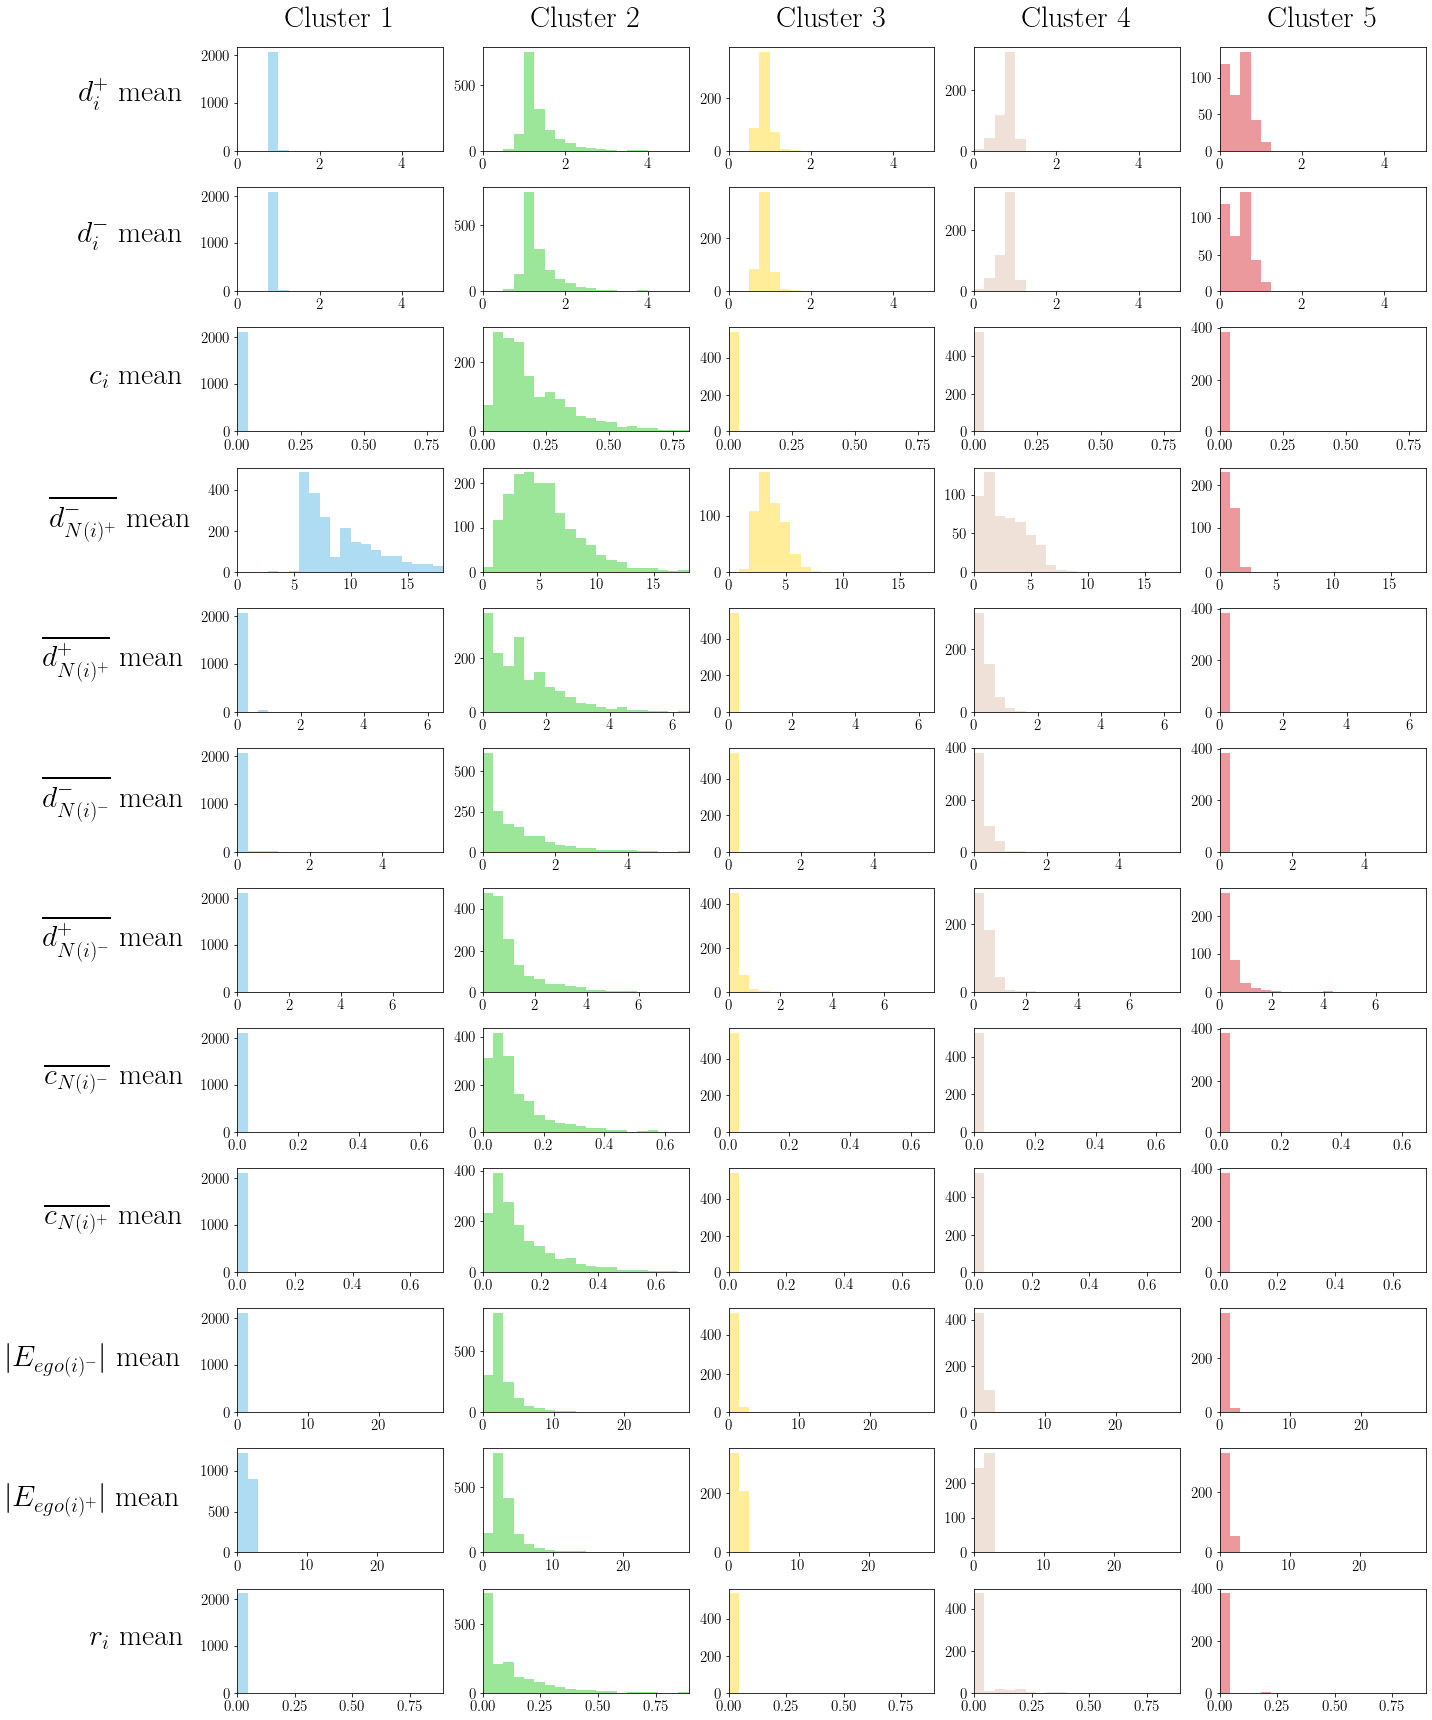

In [61]:
pad=10
fig = plt.figure(figsize=(n_partitions*4, len(feature_selection1)*2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, n_partitions+1):
    for no,j in enumerate(feature_selection1):
        ax = fig.add_subplot(len(feature_selection1), n_partitions, no*n_partitions + i)
        #ax.text(n_feat, n_partitions, j*n_partitions + i, fontsize=30)
        sns.distplot(distributions[str(i)+str(j)], bins=[x*(xmax[j] - xmin[j])/nbins for x in range(nbins+1)], hist=True, color=colors[i-1], kde=False)
        if i==1:
            ax.annotate(feature_labels_netsimile[j], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                 fontsize=30, ha='right', va='center')
        if no==0:
            ax.set_title("Cluster " + str(i),pad=20, fontsize=30)
            #ax.set_ylabel(feature_labels_netsimile[j], fontsize=30, rotation=0)
        
        plt.xlim(xmin[j], xmax[j])
plt.tight_layout()

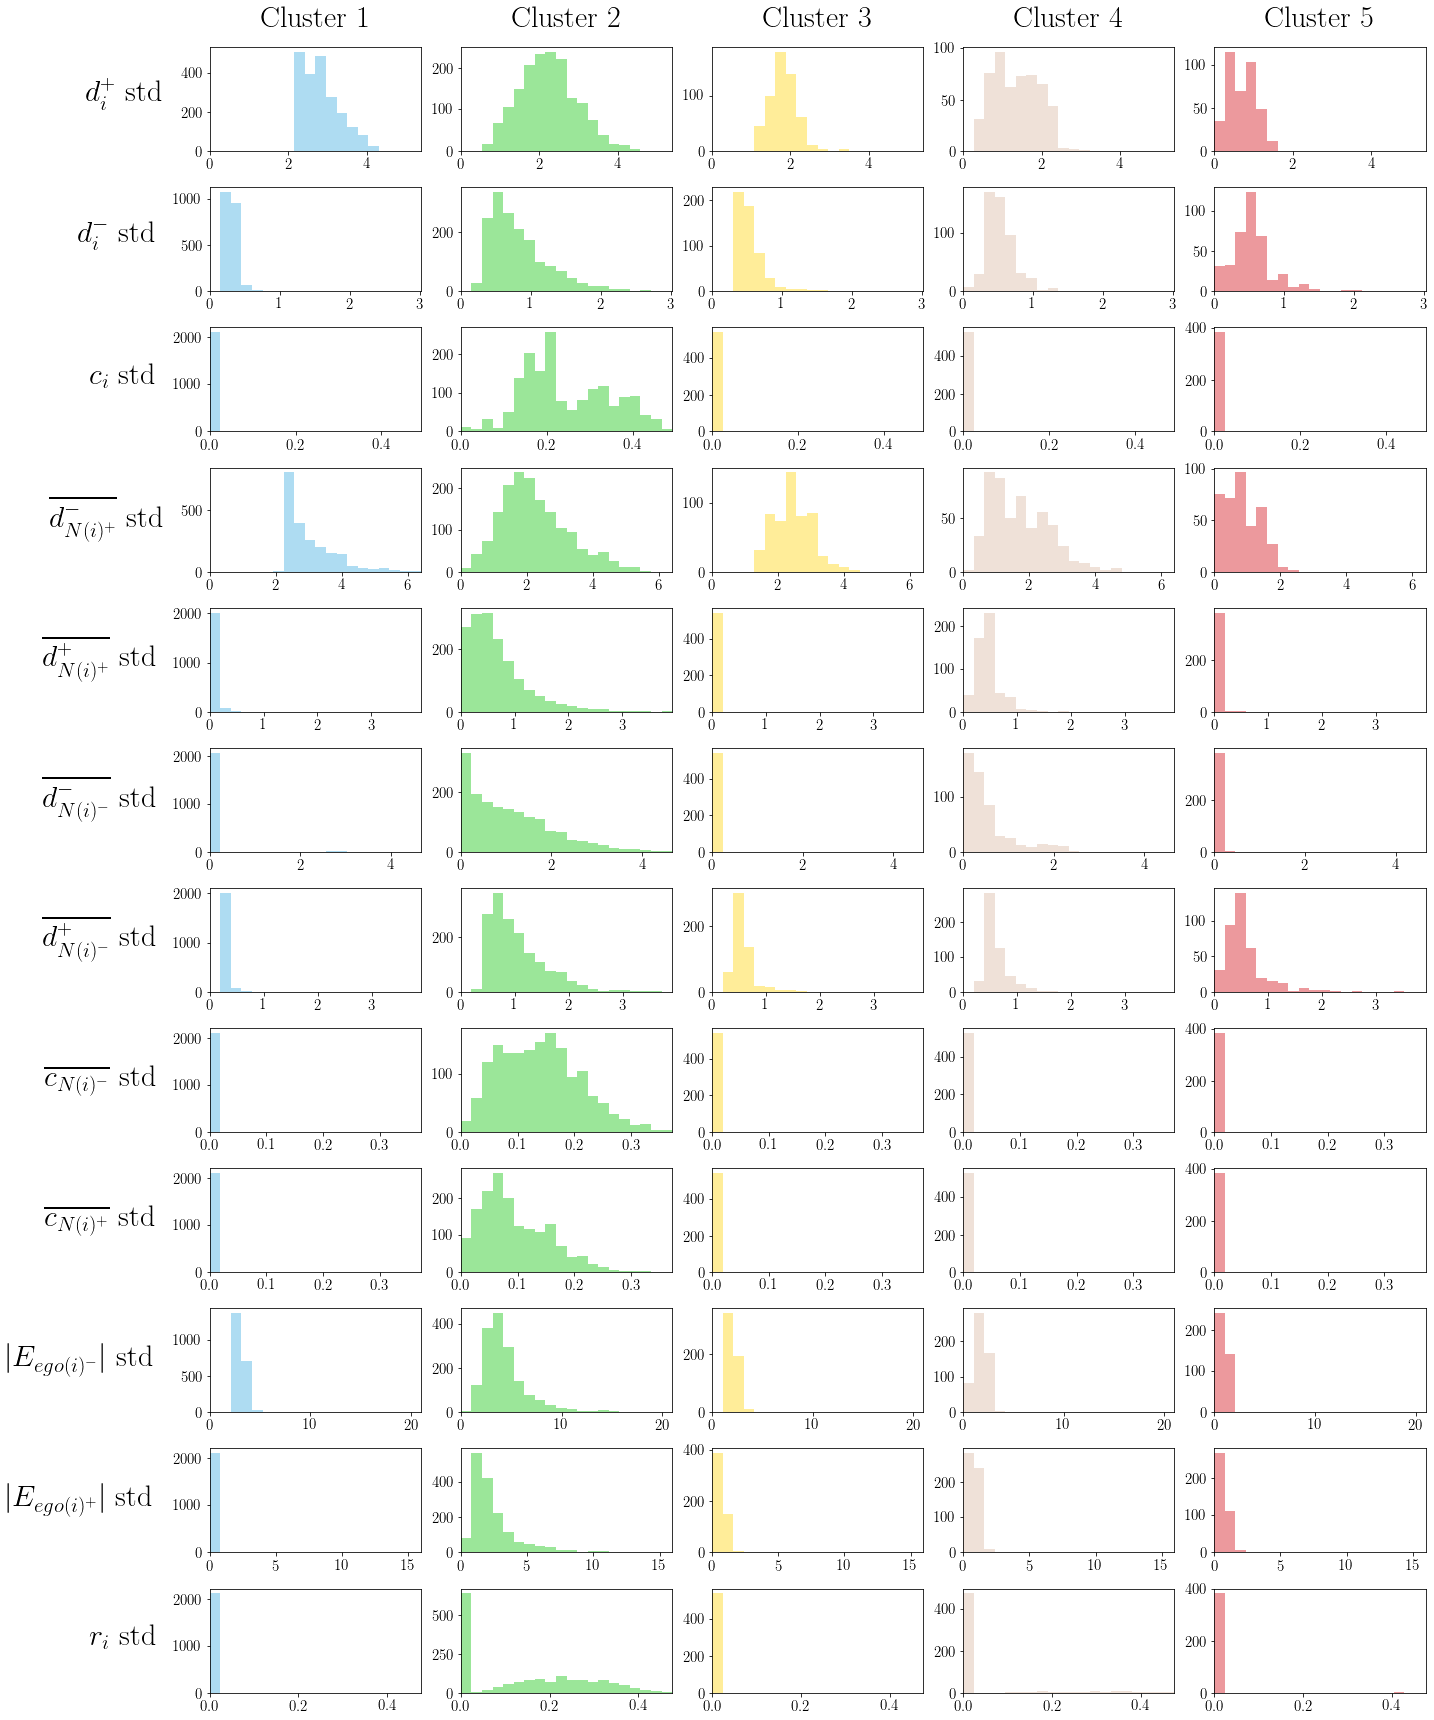

In [62]:
fig = plt.figure(figsize=(n_partitions*4, len(feature_selection2)*2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, n_partitions+1):
    for no,j in enumerate(feature_selection2):
        ax = fig.add_subplot(len(feature_selection2), n_partitions, no*n_partitions + i)
        #ax.text(n_feat, n_partitions, j*n_partitions + i, fontsize=30)
        sns.distplot(distributions[str(i)+str(j)], bins=[x*(xmax[j] - xmin[j])/nbins for x in range(nbins+1)], hist=True, color=colors[i-1], kde=False)
        if i==1:
            ax.annotate(feature_labels_netsimile[j], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                 fontsize=30, ha='right', va='center')
        if no==0:
            ax.set_title("Cluster " + str(i),pad=20, fontsize=30)
        plt.xlim(xmin[j], xmax[j])
plt.tight_layout()

# Clustering on the complete graph
As a sanity check, we cluster on an untresholded graph to see wether we get a similar result.

In [6]:
np.random.seed(seed=123)

nodes= feature_vecs_8to20.keys()
Y=distance.pdist([feature_vecs_8to20[node] for node in nodes], 'seuclidean', V=varis)

Y_min = np.min(Y)
Y_max = np.max(Y)
print(Y_min, Y_max)

tuples=combinations(nodes,2)
G=nx.Graph()
G.add_weighted_edges_from([(*indeces, 1 - (dist - Y_min)/(Y_max - Y_min)) for indeces, dist in zip(tuples,Y) ])

G_nodes=G.nodes
for node in nodes:
    if node not in G_nodes:
        G.add_node(node)
#compute the best partition

partition_complete_graph = community.best_partition(G, resolution=1.0)
modularity_complete_graph=community.modularity(partition_complete_graph, G, weight='weight')



   

0.0 59.802066817089106


In [7]:
p=partition_complete_graph
cluster0=[x for x in p if p[x]==0]
cluster1=[x for x in p if p[x]==1]
cluster2=[x for x in p if p[x]==2]
cluster3=[x for x in p if p[x]==3]

print("cluster 0: ", len(cluster0))
print("cluster 1: ", len(cluster1))
print("cluster 2: ", len(cluster2))
print("cluster 3: ", len(cluster3))


cluster 0:  2255
cluster 1:  1392
cluster 2:  1883
cluster 3:  0


Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  2.717197109913353
Project name: byte-buddy, project owner: raphw, ghtorrent id: 6613024


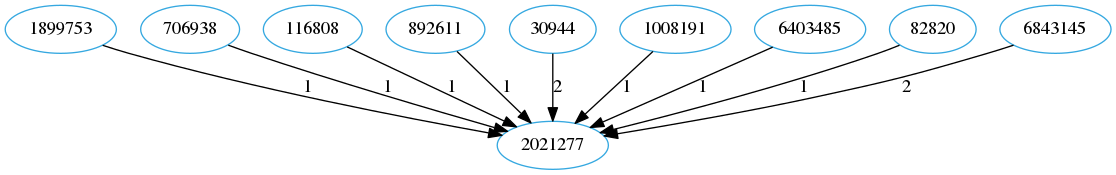

mean distance  2.717197109913353
Project name: ai-project-2016, project owner: info-ruc, ghtorrent id: 52547291


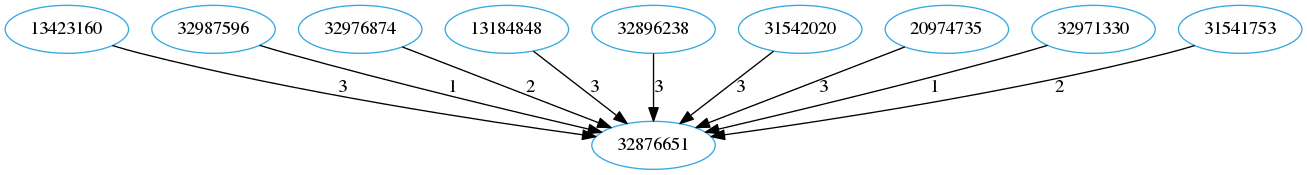

mean distance  2.717197109913353
Project name: budgie-desktop, project owner: solus-project, ghtorrent id: 18387830


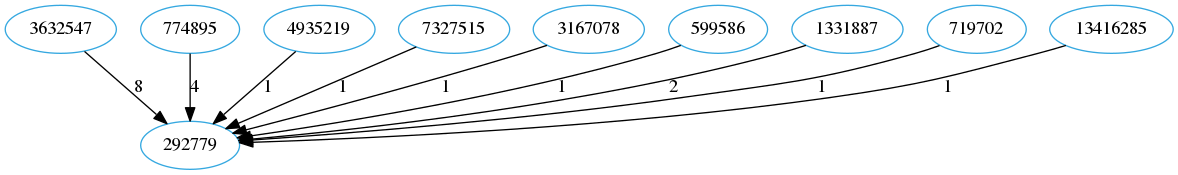

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  10.876442633681092
Project name: flatpak.github.io, project owner: flatpak, ghtorrent id: 37298662


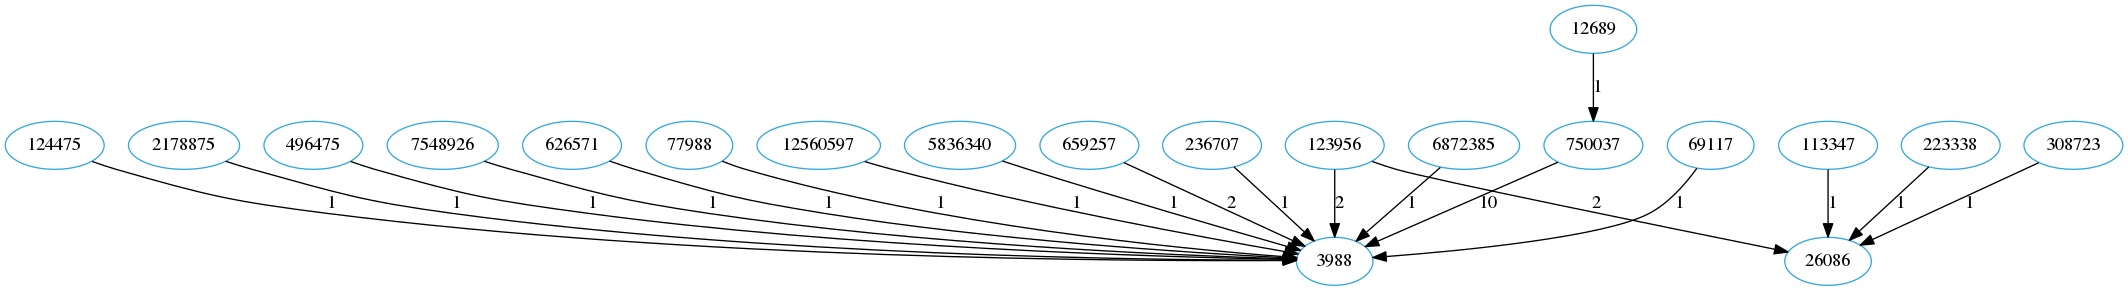

mean distance  10.90668530044818
Project name: laravel-medialibrary, project owner: Spatie, ghtorrent id: 20374325


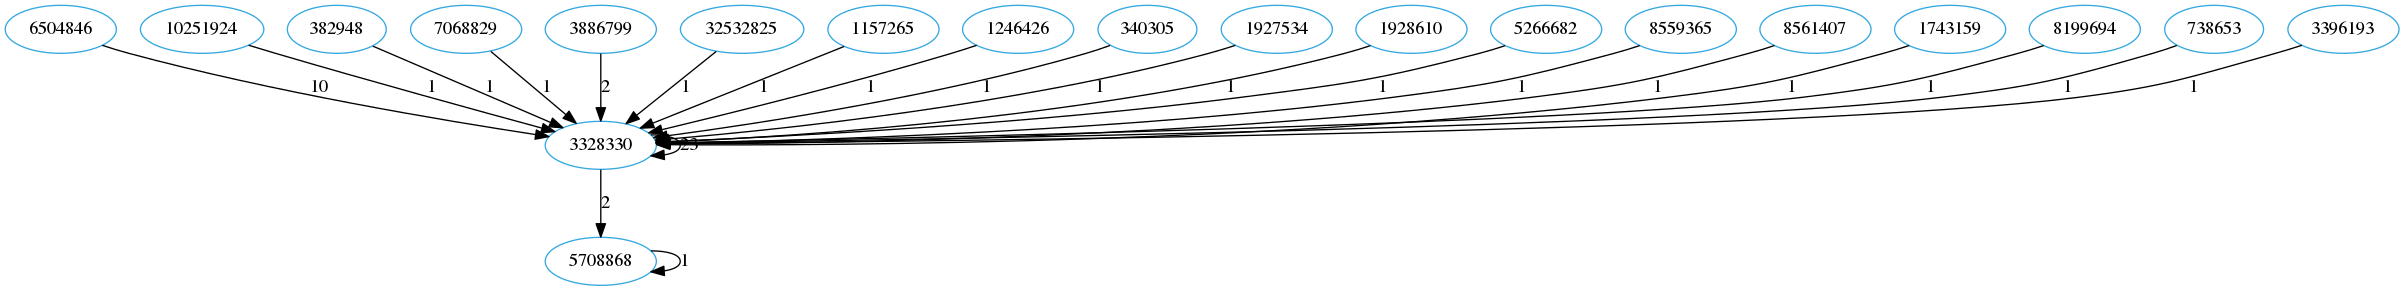

mean distance  10.993226409199757
Project name: chain, project owner: chain, ghtorrent id: 49081522


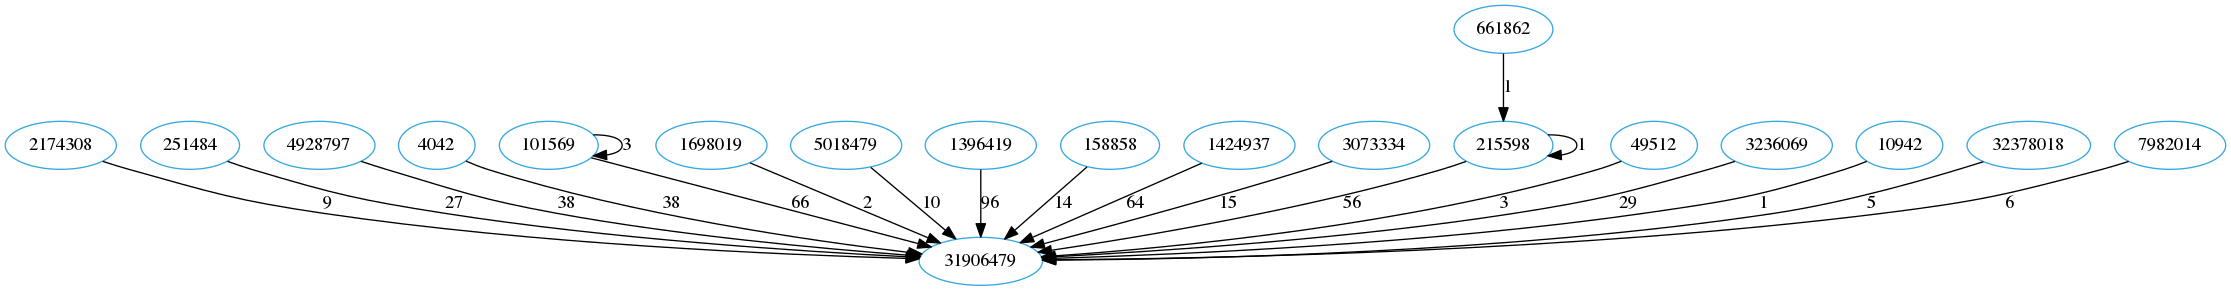

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [8]:
draw_most_representatives(cluster0, feature_vecs_8to20, 3, 0, 0, colors[0])

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  3.8063133807481373
Project name: nativescript-background-http, project owner: NativeScript, ghtorrent id: 25181147


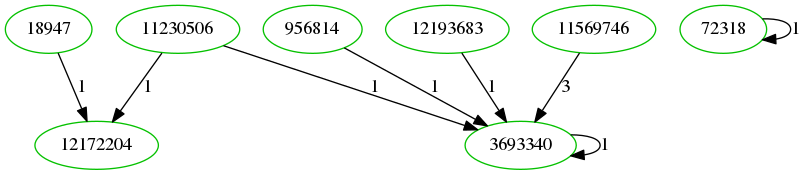

mean distance  3.8321408326219264
Project name: legion, project owner: StanfordLegion, ghtorrent id: 2939782


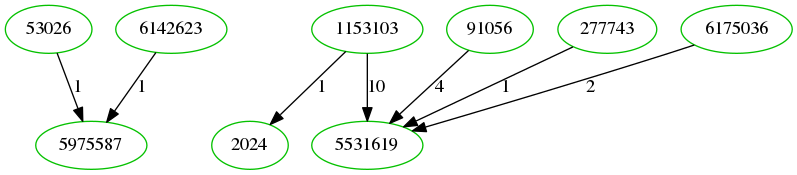

mean distance  3.8368625799899188
Project name: hyperlinks, project owner: Zeit, ghtorrent id: 41430396


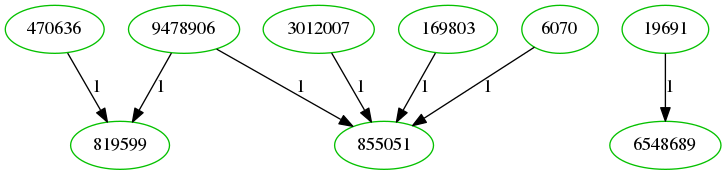

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  11.047128863130427
Project name: Common, project owner: aspnet, ghtorrent id: 16439239


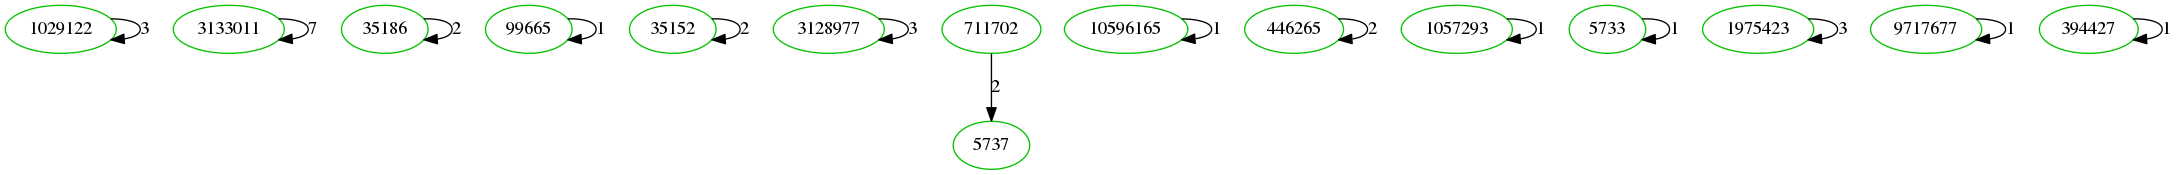

mean distance  11.799936978782574
Project name: dev-dec-19, project owner: githubteacher, ghtorrent id: 53019708


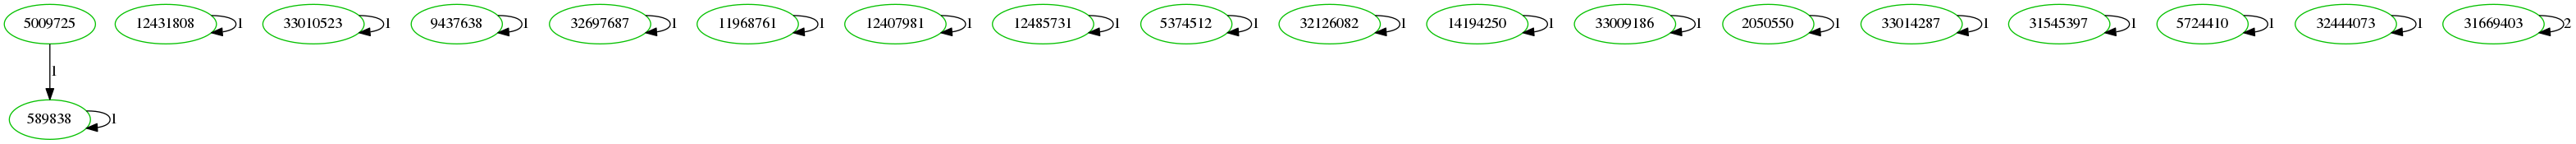

mean distance  12.81940818352291
Project name: oct-04-dev, project owner: githubteacher, ghtorrent id: 47472936


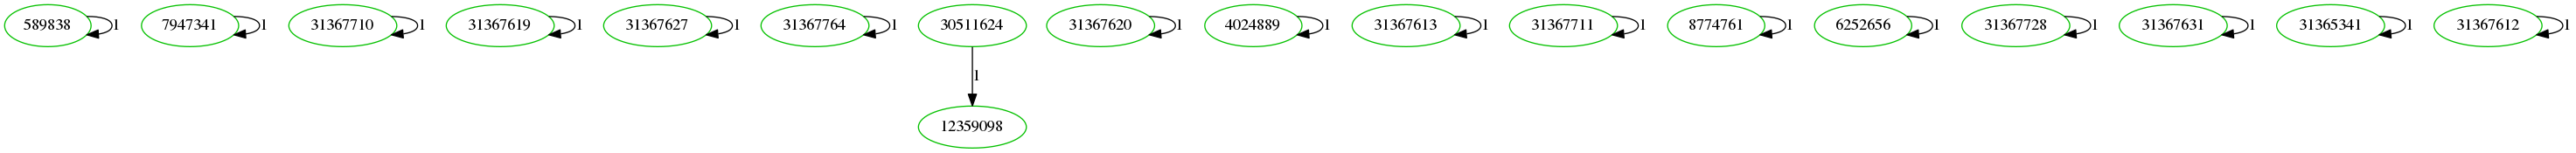

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [9]:
draw_most_representatives(cluster1, feature_vecs_8to20, 3, 0, 0, colors[1])

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  8.577839238373794
Project name: kumascript, project owner: mozilla, ghtorrent id: 52973


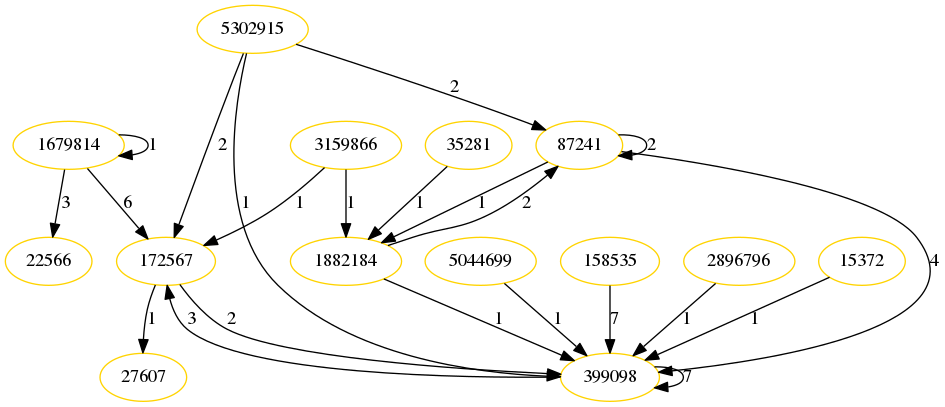

mean distance  8.578228932409543
Project name: hiyaoroshigo, project owner: matsueoss, ghtorrent id: 43818409


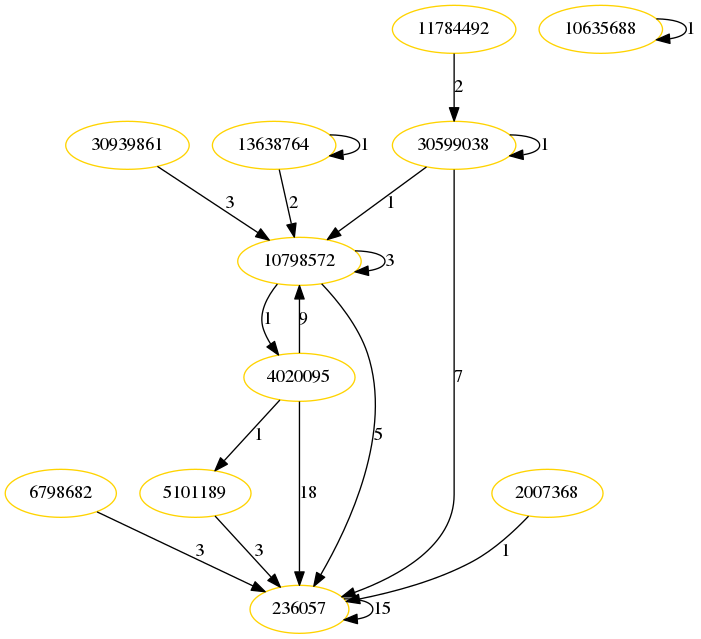

mean distance  8.618606482208683
Project name: prestashop.github.io, project owner: PrestaShop, ghtorrent id: 17251585


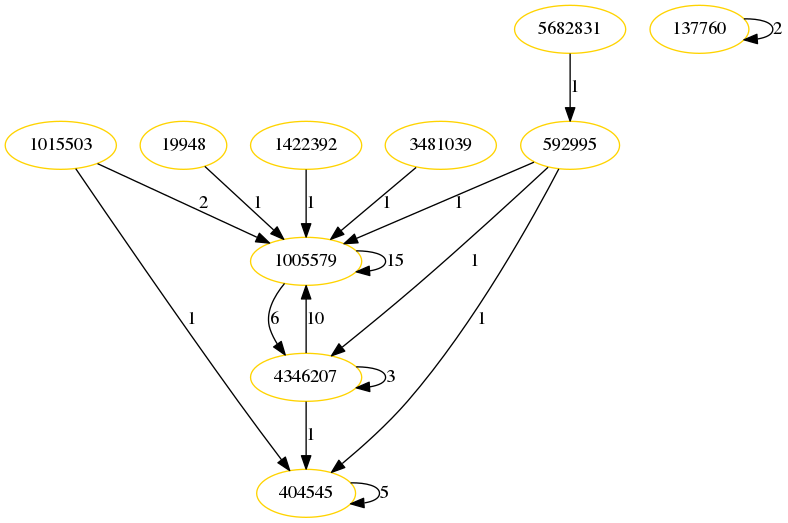

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  43.938778591672396
Project name: calcentral, project owner: ets-berkeley-edu, ghtorrent id: 424371


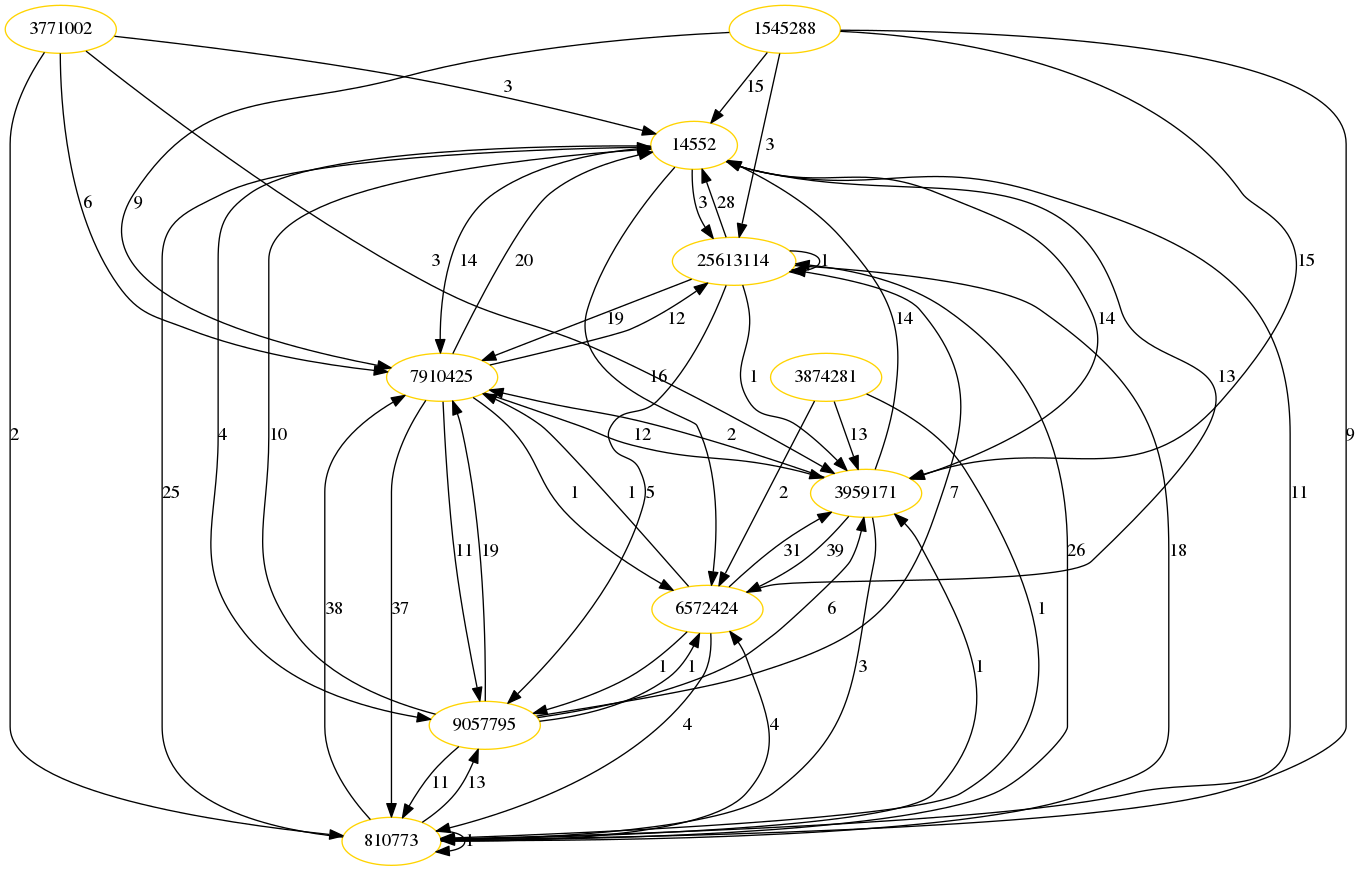

mean distance  47.78426334967299
Project name: int-perl, project owner: a-panayotopoulos, ghtorrent id: 45897740


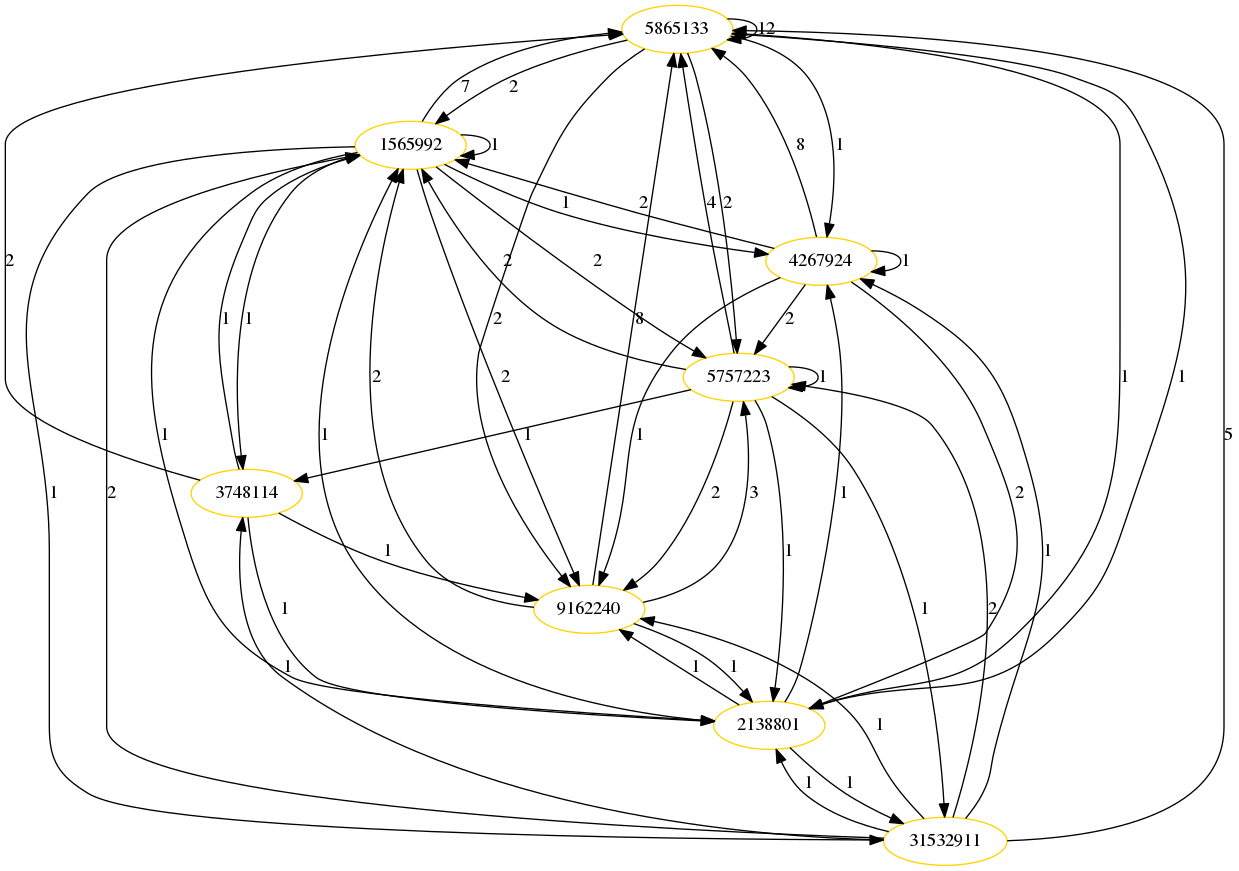

mean distance  53.32461196630464
Project name: quasar, project owner: quasar-analytics, ghtorrent id: 27825237


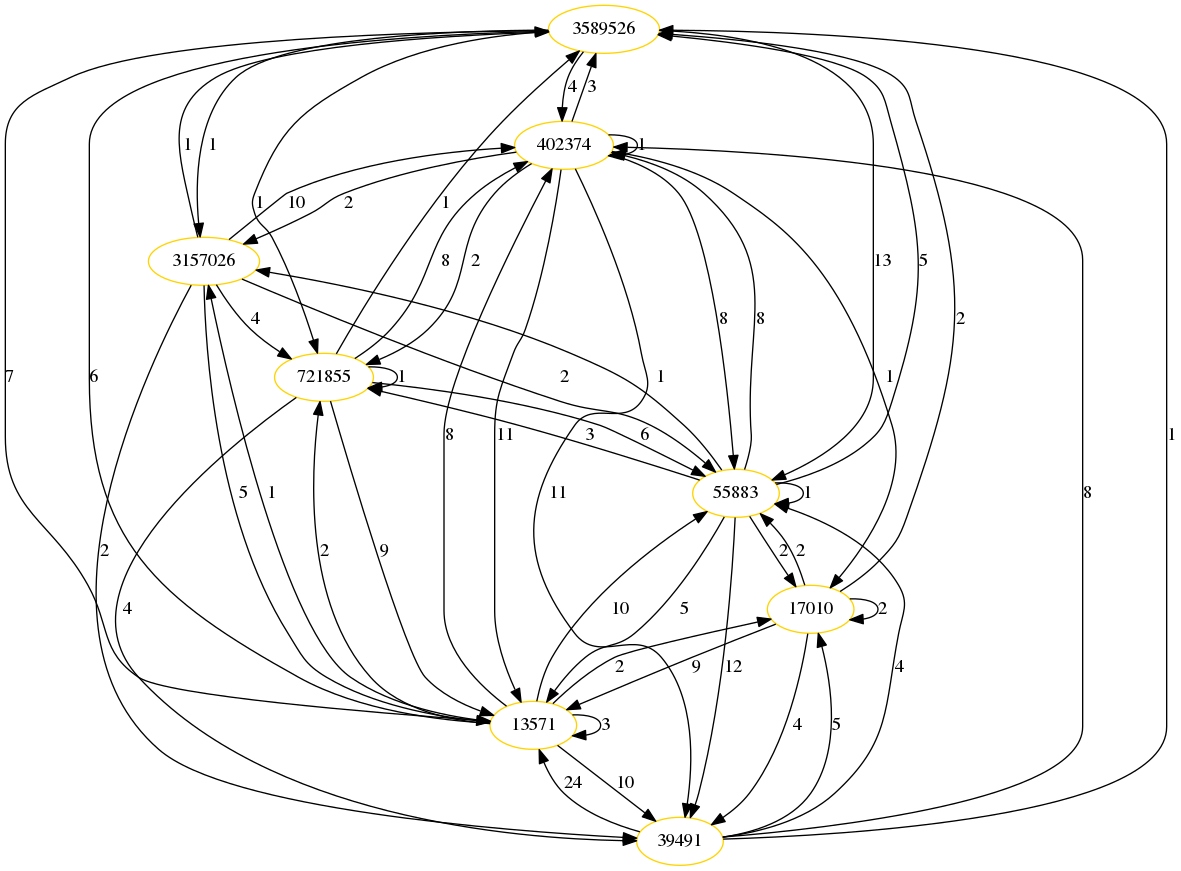

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [10]:
draw_most_representatives(cluster2, feature_vecs_8to20, 3, 0, 0, colors[2])

In [11]:
np.random.seed(seed=123)
nodes= cluster1
Y=distance.pdist([feature_vecs_8to20[node] for node in nodes], 'seuclidean', V=varis)

Y_min = np.min(Y)
Y_max = np.max(Y)

tuples=combinations(nodes,2)
G=nx.Graph()
G.add_weighted_edges_from([(*indeces, 1 - (dist - Y_min)/(Y_max - Y_min)) for indeces, dist in zip(tuples,Y) ])

G_nodes=G.nodes
for node in nodes:
    if node not in G_nodes:
        G.add_node(node)
#compute the best partition

partition2_cg = community.best_partition(G, resolution=1.0)
modularity2_cg=community.modularity(partition2_cg, G, weight='weight')

In [12]:
cluster10=[x for x in partition2_cg if partition2_cg[x]==0]
cluster11=[x for x in partition2_cg if partition2_cg[x]==1]
cluster12=[x for x in partition2_cg if partition2_cg[x]==2]
cluster13=[x for x in partition2_cg if partition2_cg[x]==3]

print("cluster 0: ", len(cluster10))
print("cluster 1: ", len(cluster11))
print("cluster 2: ", len(cluster12))
print("cluster 3: ", len(cluster13))


cluster 0:  516
cluster 1:  365
cluster 2:  511
cluster 3:  0


Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  3.819150593269999
Project name: Platform-CI, project owner: RHQE, ghtorrent id: 33806433


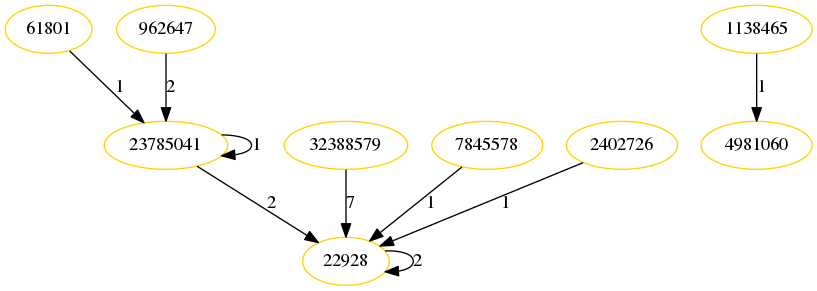

mean distance  3.859311673151167
Project name: linux-sgx, project owner: 01org, ghtorrent id: 39882805


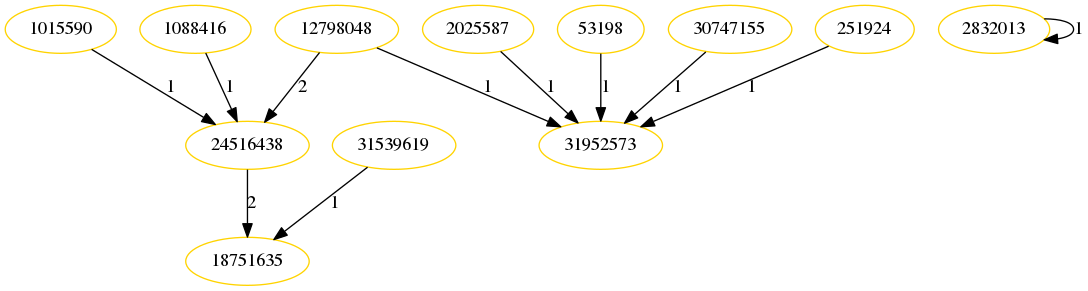

mean distance  3.9178661881097083
Project name: Magneticraft, project owner: Magneticraft-Team, ghtorrent id: 30965635


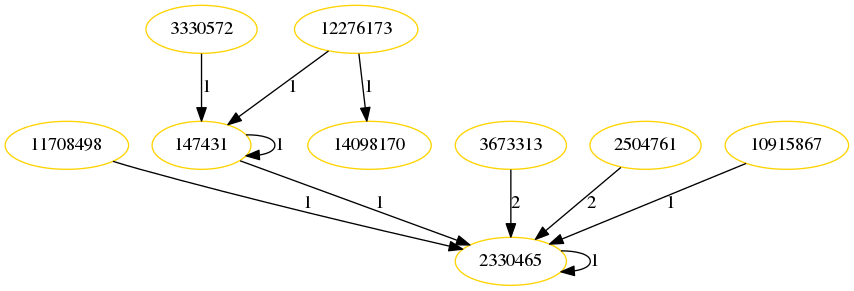

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  8.115283773253665
Project name: find-and-replace, project owner: Atom, ghtorrent id: 8233337


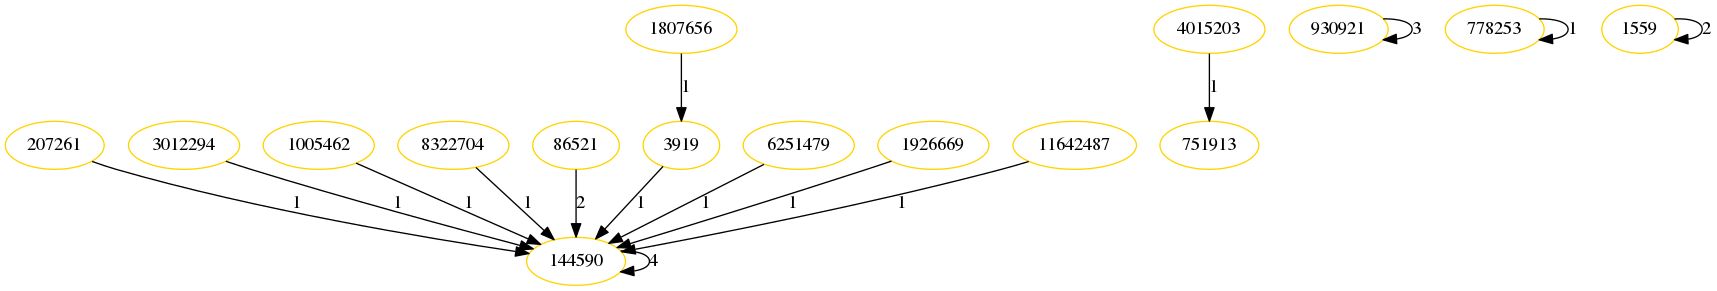

mean distance  8.820523534151855
Project name: maslow, project owner: alphagov, ghtorrent id: 5640587


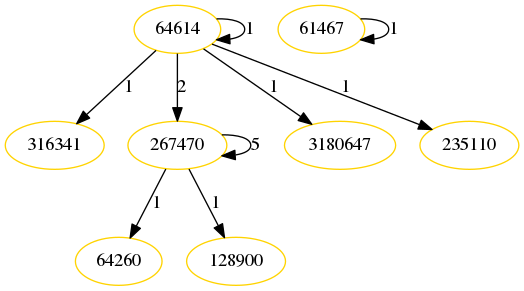

mean distance  9.383510857445273
Project name: devs-september, project owner: githubteacher, ghtorrent id: 45268976


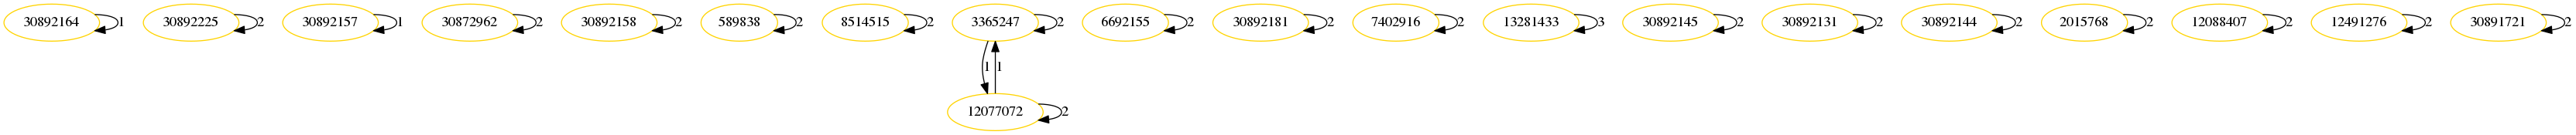

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [13]:
draw_most_representatives(cluster10, feature_vecs_8to20, 3, 0, 0, colors[2])

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  3.312521156258607
Project name: hazelcast-code-samples, project owner: hazelcast, ghtorrent id: 10304631


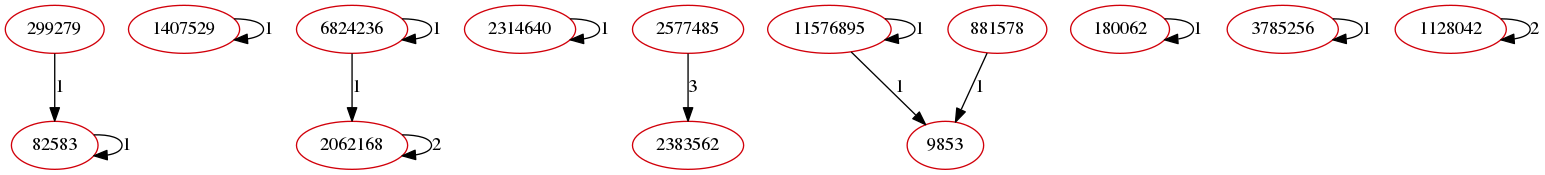

mean distance  3.3317441793064737
Project name: sentry-plugins, project owner: getsentry, ghtorrent id: 42885683


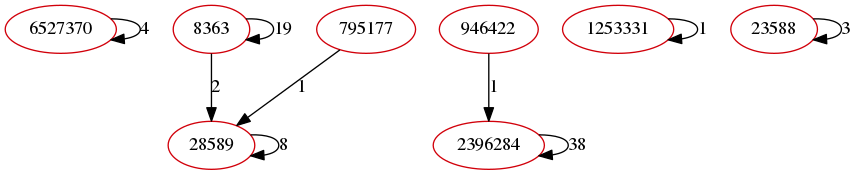

mean distance  3.3344921962876923
Project name: strong-error-handler, project owner: strongloop, ghtorrent id: 36892254


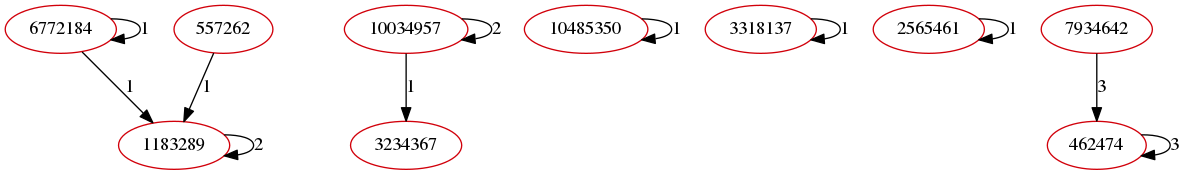

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  9.745878425070686
Project name: Common, project owner: aspnet, ghtorrent id: 16439239


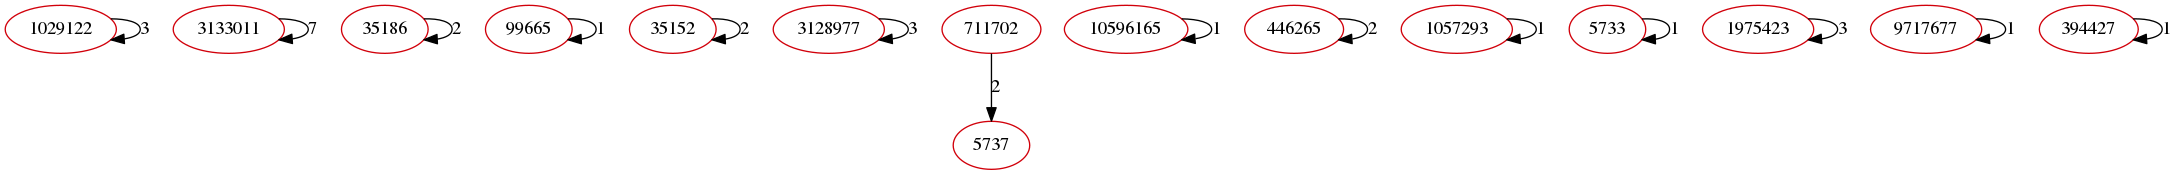

mean distance  10.55273034212481
Project name: dev-dec-19, project owner: githubteacher, ghtorrent id: 53019708


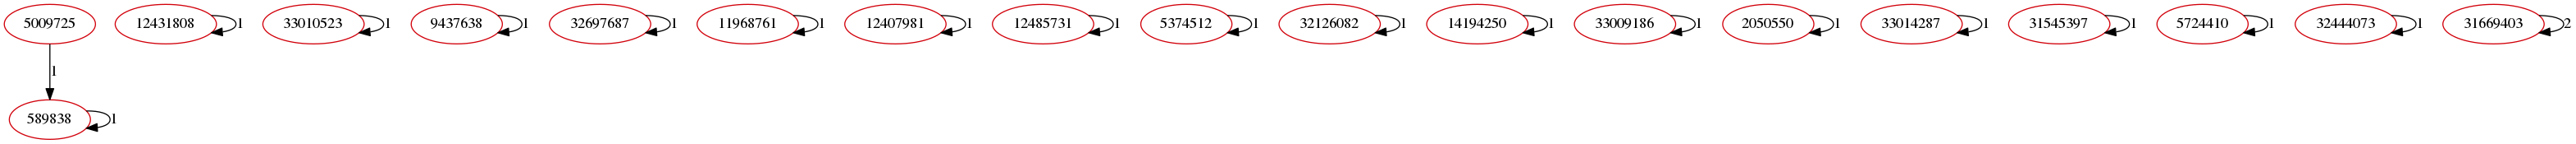

mean distance  11.640800389162306
Project name: oct-04-dev, project owner: githubteacher, ghtorrent id: 47472936


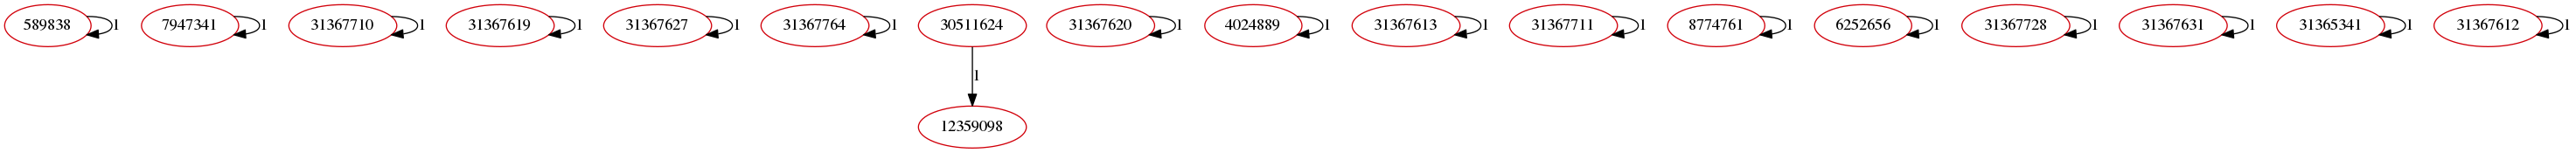

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [14]:
draw_most_representatives(cluster11, feature_vecs_8to20, 3, 0, 0, colors[4])

Distance distribution
---------------------------------------------------------------------------------
most central projects in cluster:
---------------------------------------------------------------------------------
mean distance  1.8740782005812755
Project name: opensips, project owner: OpenSIPS, ghtorrent id: 3648248


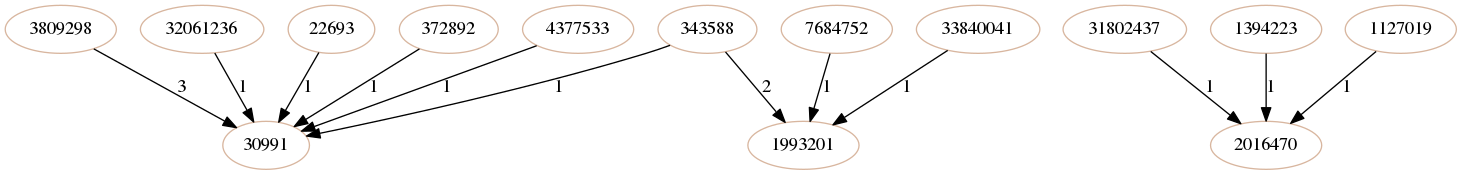

mean distance  1.8761744195713113
Project name: HackCU2017, project owner: HackCU, ghtorrent id: 36851764


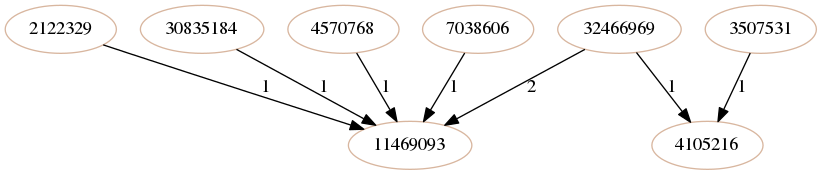

mean distance  1.8761744195713113
Project name: proxmark3, project owner: Proxmark, ghtorrent id: 8618875


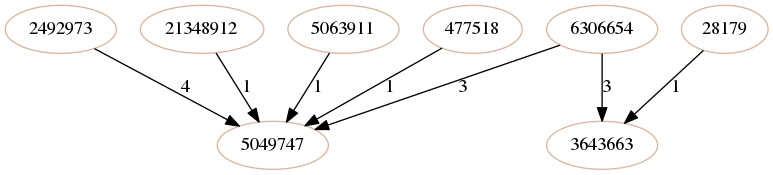

most decentral projects in cluster:
---------------------------------------------------------------------------------
mean distance  5.2699022736889525
Project name: ruby-oct-2016, project owner: CodingDojoDallas, ghtorrent id: 47480675


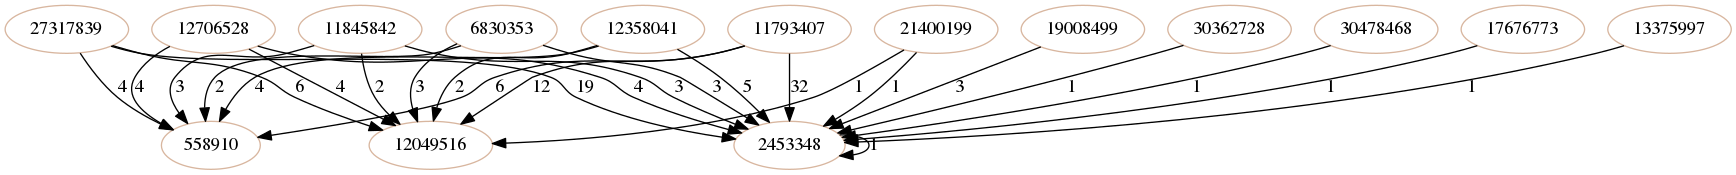

mean distance  5.536219097430243
Project name: dl-ui, project owner: danliris, ghtorrent id: 42787101


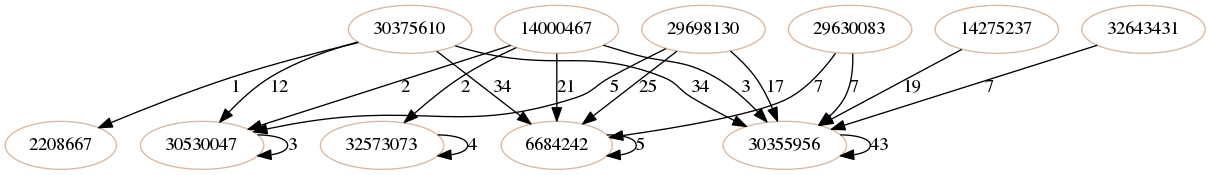

mean distance  5.61082759975953
Project name: oe-alliance-plugins, project owner: oe-alliance, ghtorrent id: 123568


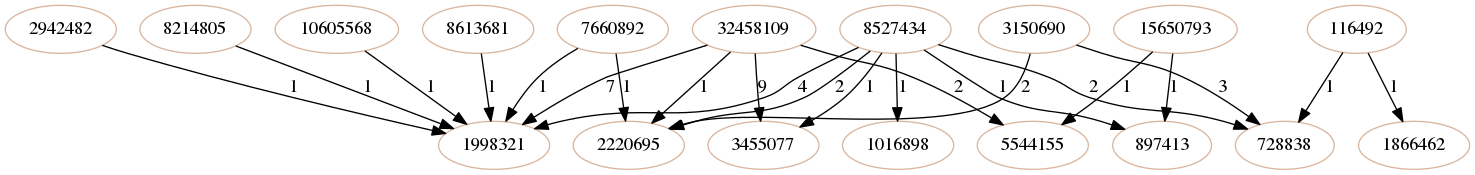

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [15]:
draw_most_representatives(cluster12, feature_vecs_8to20, 3, 0, 0, colors[3])

In [16]:
completegraph_finalpartition = {}
for node in cluster0:
    completegraph_finalpartition[node]=0

for node in cluster2:
    completegraph_finalpartition[node]=1

for node in cluster10:
    completegraph_finalpartition[node]=2
    
for node in cluster11:
    completegraph_finalpartition[node]=3

for node in cluster12:
    completegraph_finalpartition[node]=4




Since we discarded some projects before we cannot calculate the adjusted rand score as is.
But we can do so if we remove the discarded projects also from completegraph_finalpartition.

In [17]:
final_partition = pickle.load(open("data/final_partition", "rb"))

In [18]:
completegraph_finalpartition_without_garbage = {k:v for k,v in completegraph_finalpartition.items() if k in final_partition}
print(adjusted_rand_score(list(final_partition.values()), list(completegraph_finalpartition_without_garbage.values())))

0.8943811420797366


#### We see, both from the plots above and the high adjusted rand score between the partitions, that we would get a very similar partition even without using the treshold on the distance.